In [163]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

from utils import *
from plot_utils import *

import seaborn as sns
import matplotlib
from matplotlib import rcParams
from cycler import cycler

## Set plotting style and print options
sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster

d = {'lines.linewidth': 2, 'axes.titlesize': 20, 'axes.titleweight': 'bold', 'axes.labelsize': 18, 'xtick.labelsize': 12, 'axes.labelweight': 'bold', 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'font.weight': 'bold', 'figure.titlesize': 20,'figure.titleweight': 'bold',\
          'figure.labelsize': 18,'figure.labelweight': 'bold', 'figure.figsize': (9,6), }
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'brown', 'green', 'yellow', 'khaki','lightblue', 'firebrick', 'darkorange', 'darkviolet', 'darkgoldenrod', 'darkslategray', 'darkturquoise',\
             'darkmagenta', 'darkkhaki', 'darkolivegreen', 'darkseagreen', 'darkslateblue', 'darkslategrey', 'darkorchid', 'darkcyan', 'darkred', 'darkgray', 'darkgreen'])}
rcParams.update(d)
rcParams.update(d_colors)
np.set_printoptions(precision = 5, suppress=1e-10)

In [ ]:
LX = [256, 512, 1024, 2048]
prefix = ""
for L in LX:
    path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{L}_LL0.05{prefix}_sfac'
    if os.path.isdir(path):
        print(L)
        move_files(path)

In [184]:
class AnalyseDefects:
    def __init__(self, input_list, output_path = 'data'):
        """"
        input_list: list of dictionaries. Each dictionary contains the following keys:
        "path": path to the defect folder
        "suffix": suffix of the defect folder
        "priority": int: defect priority. The higher the more important and will overwrite the lower priority results
        "LX": int: system size in x direction
        "Nframes": int: number of frames in the defect folder

        """
        self.Ndata = len(input_list)
        self.input_list = input_list
        self.input_paths = [input["path"] for input in input_list]
        self.suffixes = [input["suffix"] for input in input_list]
        self.priorities = [input["priority"] for input in input_list]
        self.LX = [int(input["LX"]) for input in input_list]
        self.Nframes = [int(input["Nframes"]) for input in input_list]

        self.output_main_path = output_path 
        self.output_paths = [os.path.join(self.output_main_path, self.suffixes[i]) for i in range(self.Ndata)]
        self.Nexp = []
        self.Nactivity = []
        self.act_list = []
        self.act_dir_list = []
        self.window_sizes = []
        self.conv_list = []
        
        self.Ndata = len(input_list)

        
        for i, input in enumerate(self.input_paths):
            Nsubdir = 1
            act = []
            act_dir = []
            self.Nactivity.append(len(os.listdir(input)))
            for j, subdir in enumerate(os.listdir(input)):
        
                subdir_full = os.path.join(input, subdir)
                act.append(np.round(float(subdir_full.split('_')[-1]),4))
                act_dir.append(subdir_full)
                Nsubdir = max(Nsubdir, len(os.listdir(os.path.join(input, subdir))))

                if not os.path.isdir(self.output_paths[i]):
                    os.makedirs(self.output_paths[i])

                if not os.path.isfile(os.path.join(self.output_paths[i], 'window_sizes.txt')):
                    subsubdir = os.path.join(subdir_full, os.listdir(subdir_full)[0])
                    dir_windows = os.path.join(subsubdir, 'window_sizes.txt')
                    windows = np.loadtxt(dir_windows)   
                    np.savetxt(os.path.join(self.output_paths[i], 'window_sizes.txt'), windows)
                else:
                    windows = np.loadtxt(os.path.join(self.output_paths[i], 'window_sizes.txt'))
                self.window_sizes.append(windows)
                    
                if not os.path.isfile(os.path.join(self.output_paths[i], 'kbins.txt')) or not os.path.isfile(os.path.join(self.output_paths[i], 'rad.txt')):
                    subsubdir = os.path.join(subdir_full, os.listdir(subdir_full)[0])
                    dir_kbins = os.path.join(subsubdir, 'kbins.txt')
                    dir_rad = os.path.join(subsubdir, 'rad.txt')

                    # save the kbins and rad if they exist
                    if os.path.isfile(dir_kbins):
                        kbins = np.loadtxt(dir_kbins)
                        np.savetxt(os.path.join(self.output_paths[i], 'kbins.txt'), kbins)
                    if os.path.isfile(dir_rad):
                        rad = np.loadtxt(dir_rad)
                        np.savetxt(os.path.join(self.output_paths[i], 'rad.txt'), rad)
       
            act, act_dir = zip(*sorted(zip(act, act_dir)))

            # save the activity list
            np.savetxt(os.path.join(self.output_paths[i], 'activity_list.txt'), act)

            self.act_list.append(act)
            self.act_dir_list.append(act_dir)
            self.Nexp.append(Nsubdir)

        for i, output in enumerate(self.output_paths):
            if not os.path.exists(output):
                os.makedirs(output)
            if not os.path.exists(os.path.join(output, 'figs')):
                os.makedirs(os.path.join(output, 'figs'))   

            # load the convergence list if it exists
            try:
                self.conv_list.append(np.loadtxt(os.path.join(output, 'conv_list.txt')).astype(int))
            except:
                self.conv_list.append([0] * self.Nactivity[i])

    def __calc_binder(self, Ndataset = 0):

        defect_arr = self.get_arrays_full(Ndataset=Ndataset)[0]

        act_list = self.act_list[Ndataset]
        conv_list = self.conv_list[Ndataset]
        Nact = len(act_list)

        p4 = defect_arr ** 4
        p2 = defect_arr ** 2

        binder_cumulants = np.zeros([Nact, 2]) * np.nan
        p4_av = np.zeros(Nact)
        p2_av = np.zeros(Nact)
        p4_std = np.zeros(Nact)
        p2_std = np.zeros(Nact)

        for i, act in enumerate(act_list):
            Npoints = p4[conv_list[i]:,i,:].size
            p4_av[i] = np.nanmean(np.nanmean(p4[conv_list[i]:,i,:]))
            p2_av[i] = np.nanmean(np.nanmean(p2[conv_list[i]:,i,:]))
            p4_std[i] = np.nanstd(p4[conv_list[i]:,i,:]) / np.sqrt(Npoints)
            p2_std[i] = np.nanstd(p2[conv_list[i]:,i,:]) / np.sqrt(Npoints)
       
        binder_cumulants[:,0] = 1 - p4_av / (3 * p2_av ** 2)

        # find the error in the binder cumulant
        dzdx = lambda x, y: - 1 / (3 * y ** 2)
        dzdy = lambda x, y: 2 * x / (3 * y ** 3)

        correlation = calc_corr_matrix(np.array([p4_av, p2_av]).T)[0,1]
        binder_cumulants[:,1] = prop_err(dzdx, dzdy, p4_av, p2_av, p4_std, p2_std, correlation = correlation)

        return binder_cumulants

    def extract_results(self, save = True, normalize = True,):
        """
        Analyse the defects for all the input folders
        """
        for N in range(self.Ndata):

            defect_arr = np.nan * np.zeros((self.Nframes[N], self.Nactivity[N], self.Nexp[N]))
            av_counts = np.nan * np.zeros([self.Nframes[N], len(self.window_sizes[N]), self.Nactivity[N], self.Nexp[N]])
            var_counts = np.nan * np.zeros_like(av_counts)

            if os.path.isfile(os.path.join(self.output_paths[N], 'kbins.txt')):
                ext_sfac = True
                kbins = np.loadtxt(os.path.join(self.output_paths[N], 'kbins.txt'))
                rad = np.loadtxt(os.path.join(self.output_paths[N], 'rad.txt'))
                sfac = np.nan * np.zeros((self.Nframes[N], len(kbins), 2, self.Nactivity[N], min(10, self.Nexp[N])))
                pcf = np.nan * np.zeros((self.Nframes[N], len(rad), self.Nactivity[N], min(self.Nexp[N], 10)))
            else:
                ext_sfac = False
            
            print('Analyse defects for input folder {}'.format(self.input_paths[N]))
            for i, (act, act_dir) in enumerate(zip(self.act_list[N], self.act_dir_list[N])):
                sfac_counter = 0
                exp_list = []
                exp_dir_list = []

                for file in os.listdir(act_dir):
                    exp_count = file.split('_')[-1]
                    exp_list.append(int(exp_count))
                    exp_dir_list.append(os.path.join(act_dir, file))

                # sort the activity list and the activity directory list
                exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

                for j, (exp, exp_dir) in enumerate(zip(exp_list, exp_dir_list)):
                    defect_arr[:, i, j] = np.loadtxt(os.path.join(exp_dir, 'Ndefects_act{}_exp{}.txt'.format(act, exp)))[-self.Nframes[N]:]

                    counts = np.loadtxt(os.path.join(exp_dir, 'av_counts_act{}_exp{}.txt'.format(act,exp)))[-self.Nframes[N]:,:]
                    vars = np.loadtxt(os.path.join(exp_dir, 'count_fluctuations_act{}_exp{}.txt'.format(act,exp)))[-self.Nframes[N]:,:]

                    idx_start_count = min(self.Nframes[N], len(counts))
                    av_counts[-idx_start_count:, :, i, j] = counts[-idx_start_count:, :]
                    var_counts[-idx_start_count:, :, i, j] = vars[-idx_start_count:, :]

                    if ext_sfac and sfac_counter < 10:
                        try:
                            sfac[-self.Nframes[N]:, :, :, i, sfac_counter] = np.load(os.path.join(exp_dir, 'structure_factor_act{}_exp{}.npy'.format(act,exp)))[-self.Nframes[N]:, :,:]
                        except:
                            pass
                        try:
                            pcf[-idx_start_count:, :, i, sfac_counter] = np.loadtxt(os.path.join(exp_dir, 'pcf.txt'.format(act,exp)))[-self.Nframes[N]:,:]
                        except:
                            pass
                        if os.path.isfile(os.path.join(exp_dir,'sfac_analysis_completed.txt')):
                            sfac_counter += 1
      
            dens_fluc = var_counts / (np.pi * self.window_sizes[N][:, None, None] ** 2) ** 2
            if normalize:
                av_dens = defect_arr / self.LX[N] ** 2
                dens_fluc = dens_fluc / av_dens[:, None, :, :] ** 2

            if save:
                np.save(os.path.join(self.output_paths[N], 'defect_arr.npy'), defect_arr)
                np.save(os.path.join(self.output_paths[N], 'av_counts.npy'), av_counts)
                np.save(os.path.join(self.output_paths[N], 'var_counts.npy'), var_counts)
                np.save(os.path.join(self.output_paths[N], 'dens_fluc.npy'), dens_fluc)

                if ext_sfac:
                    np.save(os.path.join(self.output_paths[N], 'sfac.npy'), sfac)
                    np.save(os.path.join(self.output_paths[N], 'pcf.npy'), pcf)

    def analyze_defects(self, Ndataset_list = None, save = True,):
        Ndataset_list = range(self.Ndata) if Ndataset_list is None else Ndataset_list

        for N in Ndataset_list:
            while True:
                try:
                    defect_arr = np.load(os.path.join(self.output_paths[N], 'defect_arr.npy'))
                    av_counts = np.load(os.path.join(self.output_paths[N], 'av_counts.npy'))
                    var_counts = np.load(os.path.join(self.output_paths[N], 'var_counts.npy'))
                    dens_fluc = np.load(os.path.join(self.output_paths[N], 'dens_fluc.npy'))
                    break
                except:
                    print('Defect array not found. They will be extracted now using normalize = True')
                    self.extract_results(save = True, normalize = True)

            if len(np.unique(self.conv_list[N])) == 1:
                print(f'NB: All simulations are set to converge at the first frame for dataset {N}. To change this, call update_conv_list.\n')

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                defect_arr_av = np.nanmean(defect_arr, axis = -1)
                defect_arr_std = np.nanstd(defect_arr, axis = -1) / np.sqrt(self.Nexp[N])
                av_counts_av = np.nanmean(av_counts, axis = -1)
                av_counts_std = np.nanstd(av_counts, axis = -1) / np.sqrt(self.Nexp[N])
                var_counts_av = np.nanmean(var_counts, axis = -1)
                var_counts_std = np.nanstd(var_counts, axis = -1) / np.sqrt(self.Nexp[N])
                dens_fluc_av = np.nanmean(dens_fluc, axis = -1)
                dens_fluc_std = np.nanstd(dens_fluc, axis = -1) / np.sqrt(self.Nexp[N])
  
                av_defects = np.zeros((self.Nactivity[N], 2))
                susceptibility = np.zeros((len(self.window_sizes[N]), self.Nactivity[N], 2)) * np.nan

                for i, act in enumerate(self.act_list[N]):
                    av_defects[i, 0] = np.mean(defect_arr_av[self.conv_list[N][i]:, i])
                    av_defects[i, 1] = np.mean(defect_arr_std[self.conv_list[N][i]:, i]) / np.sqrt(self.Nframes[N] - self.conv_list[N][i])
                    susceptibility[:, i, 0] = np.nanmean(dens_fluc_av[self.conv_list[N][i]:, :, i], axis = 0)
                    susceptibility[:, i, 1] = np.nanstd(dens_fluc_av[self.conv_list[N][i]:, :, i], axis = 0) / np.sqrt(self.Nframes[N] - self.conv_list[N][i])
        
                susceptibility[:, :, 0] *= av_defects[:, 0][None, :]
                susceptibility[:, :, 1] *= av_defects[:, 0][None, :]

                binder_cumulants = self.__calc_binder(Ndataset = N)
 
                if save:
                    np.save(os.path.join(self.output_paths[N], 'defect_arr_av.npy'), defect_arr_av)
                    np.save(os.path.join(self.output_paths[N], 'defect_arr_std.npy'), defect_arr_std)
                    np.save(os.path.join(self.output_paths[N], 'av_counts_av.npy'), av_counts_av)
                    np.save(os.path.join(self.output_paths[N], 'av_counts_std.npy'), av_counts_std)
                    np.save(os.path.join(self.output_paths[N], 'var_counts_av.npy'), var_counts_av)
                    np.save(os.path.join(self.output_paths[N], 'var_counts_std.npy'), var_counts_std)
                    np.save(os.path.join(self.output_paths[N], 'dens_fluc_av.npy'), dens_fluc_av)
                    np.save(os.path.join(self.output_paths[N], 'dens_fluc_std.npy'), dens_fluc_std)
                    np.save(os.path.join(self.output_paths[N], 'av_defects.npy'), av_defects)
                    np.save(os.path.join(self.output_paths[N], 'susceptibility.npy'), susceptibility)
                    np.save(os.path.join(self.output_paths[N], 'binder_cumulants.npy'), binder_cumulants)

                if os.path.isfile(os.path.join(self.output_paths[N], 'sfac.npy')):
                    sfac = np.load(os.path.join(self.output_paths[N], 'sfac.npy'))       
                    sfac_av = np.nan * np.zeros((sfac.shape[0], sfac.shape[1], sfac.shape[3], 2))
                    sfac_av_unweighted = np.nan * np.zeros((sfac.shape[0], sfac.shape[1], sfac.shape[3], 2))
                    sfac_time_av = np.nan * np.zeros((sfac.shape[1], sfac.shape[3], 2))
                    sfac_time_av_unweighted = np.nan * np.zeros((sfac.shape[1], sfac.shape[3], 2))

                    sfac_av[:, :, :, 0], sfac_av[:, :, :, 1] = calc_weighted_mean(sfac[:, :, 0, :, :], sfac[:, :, 1, :, :], axis = -1)
                    sfac_av_unweighted[:, :, :, 0]  = np.nanmean(sfac[:, :, 0, :, :], axis = -1)
                    sfac_av_unweighted[:, :, :, 1]  = np.nanstd(sfac[:, :, 0, :, :], axis = -1) / np.sqrt(min(10,self.Nexp[N]))

                    for i, act in enumerate(self.act_list[N]):
                        sfac_time_av[:, i, 0], sfac_time_av[:, i, 1] = calc_weighted_mean(sfac_av[self.conv_list[N][i]:, :, i, 0], sfac_av[self.conv_list[N][i]:, :, i, 1], axis = 0)
                        sfac_time_av_unweighted[:, i, 0], sfac_time_av_unweighted[:, i, 1] = \
                            calc_weighted_mean(sfac_av_unweighted[self.conv_list[N][i]:, :, i, 0], sfac_av_unweighted[self.conv_list[N][i]:, :, i, 1], axis = 0)

                    if save:
                        np.save(os.path.join(self.output_paths[N], 'sfac_av.npy'), sfac_av)
                        np.save(os.path.join(self.output_paths[N], 'sfac_time_av.npy'), sfac_time_av)
                        np.save(os.path.join(self.output_paths[N], 'sfac_av_unweighted.npy'), sfac_av_unweighted)
                        np.save(os.path.join(self.output_paths[N], 'sfac_time_av_unweighted.npy'), sfac_time_av_unweighted) 

                if os.path.isfile(os.path.join(self.output_paths[N], 'pcf.npy')):
                    pcf = np.load(os.path.join(self.output_paths[N], 'pcf.npy'))
                    pcf_av = np.nan * np.zeros((*pcf.shape[:-1], 2))
                    pcf_time_av = np.nan * np.zeros((pcf.shape[1], pcf.shape[2], 2))

                    pcf_av[:, :, :, 0] = np.nanmean(pcf, axis = -1)
                    pcf_av[:, :, :, 1] = np.nanstd(pcf, axis = -1) / np.sqrt(self.Nexp[N])

                    for i, act in enumerate(self.act_list[N]):
                        pcf_time_av[:, i, 0], pcf_time_av[:, i, 1] = calc_weighted_mean(pcf_av[self.conv_list[N][i]:, :, i, 0], pcf_av[self.conv_list[N][i]:, :, i, 1], axis = 0)

                    if save:
                        np.save(os.path.join(self.output_paths[N], 'pcf_av.npy'), pcf_av)
                        np.save(os.path.join(self.output_paths[N], 'pcf_time_av.npy'), pcf_time_av)
        return

    def merge_results(self, save_path = None, save = True):

        if save_path is None:
            save_path = os.path.join(self.output_main_path, 'merged_results')
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        Nbase = np.argmin(self.priorities)
        Nbase_frames = self.Nframes[Nbase]
        window_sizes = self.window_sizes[Nbase]

        try:
            # load the results from the base dataset
            defect_arr_av = np.load(os.path.join(self.output_paths[Nbase], 'defect_arr_av.npy'))
            defect_arr_std = np.load(os.path.join(self.output_paths[Nbase], 'defect_arr_std.npy'))
            av_counts_av = np.load(os.path.join(self.output_paths[Nbase], 'av_counts_av.npy'))  
            av_counts_std = np.load(os.path.join(self.output_paths[Nbase], 'av_counts_std.npy'))
            var_counts_av = np.load(os.path.join(self.output_paths[Nbase], 'var_counts_av.npy'))
            var_counts_std = np.load(os.path.join(self.output_paths[Nbase], 'var_counts_std.npy'))
            dens_fluc_av = np.load(os.path.join(self.output_paths[Nbase], 'dens_fluc_av.npy'))
            dens_fluc_std = np.load(os.path.join(self.output_paths[Nbase], 'dens_fluc_std.npy'))
            av_defects = np.load(os.path.join(self.output_paths[Nbase], 'av_defects.npy'))
            susceptibility = np.load(os.path.join(self.output_paths[Nbase], 'susceptibility.npy'))
            binder_cumulants = np.load(os.path.join(self.output_paths[Nbase], 'binder_cumulants.npy'))
        except:
            print('Base dataset not found. Analyse defects first.')
            return
        
        if os.path.isfile(os.path.join(self.output_paths[Nbase], 'kbins.txt')):
            ext_sfac = True
            kbins = np.loadtxt(os.path.join(self.output_paths[Nbase], 'kbins.txt'))
            rad = np.loadtxt(os.path.join(self.output_paths[Nbase], 'rad.txt'))
            sfac_av = np.load(os.path.join(self.output_paths[Nbase], 'sfac_av.npy'))
            sfac_av_unweighted = np.load(os.path.join(self.output_paths[Nbase], 'sfac_av_unweighted.npy'))
            sfac_time_av = np.load(os.path.join(self.output_paths[Nbase], 'sfac_time_av.npy'))
            sfac_time_av_unweighted = np.load(os.path.join(self.output_paths[Nbase], 'sfac_time_av_unweighted.npy'))
            pcf_av = np.load(os.path.join(self.output_paths[Nbase], 'pcf_av.npy'))
            pcf_time_av = np.load(os.path.join(self.output_paths[Nbase], 'pcf_time_av.npy'))         
        else:
            ext_sfac = False

        # overwrite the activities with the ones from the other datasets according to self.priorities
        _, Nsorted = zip(*sorted(zip(self.priorities, range(self.Ndata))))

        for N in Nsorted[1:]:
           # act_min, act_max = self.act_list[N][0], self.act_list[N][-1]
            #act_min_idx = self.act_list[Nbase].index(act_min)
            #act_max_idx = self.act_list[Nbase].index(act_max) + 1
           # act_list = self.act_list[N]
            act_idx_list = []
            for act in self.act_list[N]:
                act_idx_list.append(self.act_list[Nbase].index(act))

            defect_arr_av[:, act_idx_list] = np.load(os.path.join(self.output_paths[N], 'defect_arr_av.npy'))[-Nbase_frames:]
            defect_arr_std[:, act_idx_list] = np.load(os.path.join(self.output_paths[N], 'defect_arr_std.npy'))[-Nbase_frames:]

            var_counts_av[:, :, act_idx_list] = np.load(os.path.join(self.output_paths[N], 'var_counts_av.npy'))[-Nbase_frames:]
            var_counts_std[:, :, act_idx_list] = np.load(os.path.join(self.output_paths[N], 'var_counts_std.npy'))[-Nbase_frames:]

            dens_fluc_av[:, :, act_idx_list] = np.load(os.path.join(self.output_paths[N], 'dens_fluc_av.npy'))[-Nbase_frames:]
            dens_fluc_std[:, :, act_idx_list] = np.load(os.path.join(self.output_paths[N], 'dens_fluc_std.npy'))[-Nbase_frames:]

            av_counts_av[:, :, act_idx_list] = np.load(os.path.join(self.output_paths[N], 'av_counts_av.npy'))[-Nbase_frames:]
            av_counts_std[:, :, act_idx_list] = np.load(os.path.join(self.output_paths[N], 'av_counts_std.npy'))[-Nbase_frames:]

            av_defects[act_idx_list] = np.load(os.path.join(self.output_paths[N], 'av_defects.npy'))
            susceptibility[:, act_idx_list, :] = np.load(os.path.join(self.output_paths[N], 'susceptibility.npy'))
            binder_cumulants[act_idx_list, :] = np.load(os.path.join(self.output_paths[N], 'binder_cumulants.npy'))

            if ext_sfac:
                try:
                    sfac_av[:, :, act_idx_list, :] = np.load(os.path.join(self.output_paths[N], 'sfac_av.npy'))[-Nbase_frames:]
                    sfac_av_unweighted[:, :, act_idx_list, :] = np.load(os.path.join(self.output_paths[N], 'sfac_av_unweighted.npy'))[-Nbase_frames:]
                    sfac_time_av[:, act_idx_list, :] = np.load(os.path.join(self.output_paths[N], 'sfac_time_av.npy'))[-Nbase_frames:]
                    sfac_time_av_unweighted[:, act_idx_list, :] = np.load(os.path.join(self.output_paths[N], 'sfac_time_av_unweighted.npy'))[-Nbase_frames:]
                except:
                    pass
                try:
                    pcf_av[:, :, act_idx_list, :] = np.load(os.path.join(self.output_paths[N], 'pcf_av.npy'))[-Nbase_frames:]
                    pcf_time_av[:, act_idx_list, :] = np.load(os.path.join(self.output_paths[N], 'pcf_time_av.npy'))[-Nbase_frames:]
                except:
                    pass
            
        if save:
            np.save(os.path.join(save_path, 'activity_list.npy'), self.act_list[Nbase])
            np.save(os.path.join(save_path, 'window_sizes.npy'), window_sizes)
            np.save(os.path.join(save_path, 'defect_arr_av.npy'), defect_arr_av)
            np.save(os.path.join(save_path, 'defect_arr_std.npy'), defect_arr_std)
            np.save(os.path.join(save_path, 'av_counts_av.npy'), av_counts_av)
            np.save(os.path.join(save_path, 'av_counts_std.npy'), av_counts_std)
            np.save(os.path.join(save_path, 'var_counts_av.npy'), var_counts_av)
            np.save(os.path.join(save_path, 'var_counts_std.npy'), var_counts_std)
            np.save(os.path.join(save_path, 'dens_fluc_av.npy'), dens_fluc_av)
            np.save(os.path.join(save_path, 'dens_fluc_std.npy'), dens_fluc_std)
            np.save(os.path.join(save_path, 'av_defects.npy'), av_defects)
            np.save(os.path.join(save_path, 'susceptibility.npy'), susceptibility)
            np.save(os.path.join(save_path, 'binder_cumulants.npy'), binder_cumulants)

            if ext_sfac:
                np.save(os.path.join(save_path, 'sfac_av.npy'), sfac_av)
                np.save(os.path.join(save_path, 'sfac_av_unweighted.npy'), sfac_av_unweighted)
                np.save(os.path.join(save_path, 'sfac_time_av.npy'), sfac_time_av)
                np.save(os.path.join(save_path, 'sfac_time_av_unweighted.npy'), sfac_time_av_unweighted)
                np.save(os.path.join(save_path, 'pcf_av.npy'), pcf_av)
                np.save(os.path.join(save_path, 'pcf_time_av.npy'), pcf_time_av)
                np.savetxt(os.path.join(save_path, 'kbins.txt'), kbins)
                np.savetxt(os.path.join(save_path, 'rad.txt'), rad)
        return
    
    def analyze_hyperuniformity(self, Ndataset = 0, fit_densities = False, fit_dict = {}, window_idx_bounds = None, \
                                act_idx_bounds = None, weighted_mean = False, use_merged = False, save = True, plot = True):
        
        suffix = 'dens' if fit_densities else 'count'

        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        if window_idx_bounds is None:
            window_idx_bounds = [0, len(self.window_sizes[Ndataset])]
        if act_idx_bounds is None:
            act_idx_bounds = [0, len(self.act_list[Ndataset])]

        window_sizes = self.window_sizes[Ndataset][window_idx_bounds[0]:window_idx_bounds[1]]
        act_list = self.act_list[Ndataset][act_idx_bounds[0]:act_idx_bounds[1]]
        if fit_densities:
            try:
                var_av = np.load(os.path.join(output_path, 'dens_fluc_av.npy'))[:, window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1]]
                var_std = np.load(os.path.join(output_path, 'dens_fluc_std.npy'))[:, window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1]]
            except:
                print('Density fluctuations not found. Analyse defects first.')
                return
        else:
            try:
                var_av = np.load(os.path.join(output_path, 'var_counts_av.npy'))[:, window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1]]
                var_std = np.load(os.path.join(output_path, 'var_counts_std.npy'))[:, window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1]]
            except:
                print('Variance of counts not found. Analyse defects first.')
                return

        if fit_dict == {}:
            if fit_densities:
                def fit_func(x, alpha, beta):
                    return beta * (- 2 - alpha) + (- 2 - alpha) * x
                param_guess = np.array([-0.1, 10])
                fit_string = rf'$y = \beta(2-\alpha) + (2-\alpha)x$'
            else:
                def fit_func(x, alpha, beta):
                    return beta * (2 - alpha) + (2 - alpha) * x
                param_guess = np.array([0.1, 0.3])
                fit_string = rf'$y = \beta(2-\alpha) + (2-\alpha)x$'
        else:
            fit_func = fit_dict['fit_func']
            param_guess = fit_dict['param_guess']
            fit_string = fit_dict['fit_string']

        Nparams = len(param_guess)
            
        fit_params = np.zeros([self.Nframes[Ndataset], len(act_list), 2 * Nparams]) * np.nan
        stat_arr = np.zeros([self.Nframes[Ndataset], len(act_list), 3]) * np.nan
        alpha_list = np.zeros([len(act_list), 2]) * np.nan

        for i, act in enumerate(act_list):
            for frame in range(self.conv_list[Ndataset][i], self.Nframes[Ndataset]):
                count_var_av = var_av[frame, :, i]
                count_var_std = var_std[frame, :, i]
                zero_mask = (count_var_av > 0) & (count_var_std > 0)

                if len(count_var_av[zero_mask]) < 5:
                    continue
                try:
                    x = np.log(window_sizes[zero_mask])
                    y = np.log(count_var_av[zero_mask])
                    yerr = count_var_std[zero_mask] / count_var_av[zero_mask]
                except:
                    continue
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
                    fit = do_chi2_fit(fit_func, x, y, yerr, param_guess, verbose = False)

                stat_arr[frame, i, :] = get_statistics_from_fit(fit, len(x), subtract_1dof_for_binning = False)
                fit_params[frame, i, :Nparams] = fit.values[:]
                fit_params[frame, i, Nparams:] = fit.errors[:]

            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    if weighted_mean:
                        alpha_mean, alpha_err = calc_weighted_mean_vec(fit_params[self.conv_list[Ndataset][i]:, i, 0],\
                                                fit_params[self.conv_list[Ndataset][i]:, i, Nparams])[:2]
                    else:
                        alpha_mean = np.nanmean(fit_params[self.conv_list[Ndataset][i]:, i, 0])
                        alpha_err = np.nanstd(fit_params[self.conv_list[Ndataset][i]:, i, 0]) \
                            / np.sqrt(self.Nframes[Ndataset] - self.conv_list[Ndataset][i])
            except:
                alpha_mean, alpha_err = np.nan, np.nan

            alpha_list[i] = alpha_mean, alpha_err

        print("Non-converged fits (p < 0.05): ", np.nansum((stat_arr[:, :, -1] < 0.05)))

        if save:
            np.save(os.path.join(output_path, f'fit_params_{suffix}.npy'), fit_params)
            np.save(os.path.join(output_path, f'stat_arr_{suffix}.npy'), stat_arr)
            np.save(os.path.join(output_path, f'alpha_list_{suffix}.npy'), alpha_list)
            np.save(os.path.join(output_path, f'act_list_alpha_fit.npy'), act_list)
        if plot:
            self.plot_hyperuniformity_exp_all(fit_params = fit_params, stat_arr = stat_arr, Ndataset = Ndataset, \
                                              act_idx_bounds = act_idx_bounds, use_merged = use_merged)
        return fit_params, stat_arr

    def get_arrays_full(self, Ndataset = 0,):
        """
        returns defect_arr, var_counts, dens_fluc, av_counts
        """
        output_path = self.output_paths[Ndataset]
        try:
            defect_arr = np.load(os.path.join(output_path, 'defect_arr.npy'))  
            var_counts = np.load(os.path.join(output_path, 'var_counts.npy'))
            dens_fluc = np.load(os.path.join(output_path, 'dens_fluc.npy'))
            av_counts = np.load(os.path.join(output_path, 'av_counts.npy'))
        except:
            print('Arrays not found. Analyse defects first.')
            return
        return defect_arr, var_counts, dens_fluc, av_counts
      
    def get_arrays_av(self, Ndataset = 0, return_av_counts = False, use_merged = False):
        """
        if return_av_counts:
        returns defect_arr_av, defect_arr_std, var_counts_av, var_counts_std, dens_fluc_av, dens_fluc_std, av_counts_av, av_counts_std, av_defects
        else:
        returns defect_arr_av, defect_arr_std, var_counts_av, var_counts_std, dens_fluc_av, dens_fluc_std, av_defects
        """


        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]
        try:
            defect_arr_av = np.load(os.path.join(output_path, 'defect_arr_av.npy'))
            defect_arr_std = np.load(os.path.join(output_path, 'defect_arr_std.npy'))
            var_counts_av = np.load(os.path.join(output_path, 'var_counts_av.npy'))
            var_counts_std = np.load(os.path.join(output_path, 'var_counts_std.npy'))
            dens_fluc_av = np.load(os.path.join(output_path, 'dens_fluc_av.npy'))
            dens_fluc_std = np.load(os.path.join(output_path, 'dens_fluc_std.npy'))
            av_counts_av = np.load(os.path.join(output_path, 'av_counts_av.npy'))
            av_counts_std = np.load(os.path.join(output_path, 'av_counts_std.npy'))
            av_defects = np.load(os.path.join(output_path, 'av_defects.npy'))
        except:
            print('Arrays not found. Analyse defects first.')
            return
        if return_av_counts:
            return defect_arr_av, defect_arr_std, var_counts_av, var_counts_std, dens_fluc_av, dens_fluc_std, av_counts_av, av_counts_std, av_defects
        else:
            return defect_arr_av, defect_arr_std, var_counts_av, var_counts_std, dens_fluc_av, dens_fluc_std, av_defects

    def get_binder_susceptibility(self, Ndataset = 0, use_merged = False):
        """
        returns binder_cumulants, susceptibility
        """
        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]
        try:
            binder_cumulants = np.load(os.path.join(output_path, 'binder_cumulants.npy'))
            susceptibility = np.load(os.path.join(output_path, 'susceptibility.npy'))
        except:
            print('Binder cumulants or susceptibilitites not found. Analyse defects first.')
            return
        return binder_cumulants, susceptibility

    def get_sfac(self, Ndataset = 0, time_av = True, weighted = True, use_merged = False):
        """
        returns kbins, sfac_av, rad, pcf_av
        """
        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        suffix = '' if weighted else '_unweighted'
        prefix = 'time_' if time_av else ''

        try:
            sfac_av = np.load(os.path.join(output_path, f'sfac_{prefix}av{suffix}.npy'))
            pcf_av = np.load(os.path.join(output_path, f'pcf_{prefix}av.npy'))
        except:
            print('Structure factor or pcf not found. Analyse defects first.')
            return

        rad = np.loadtxt(os.path.join(output_path, 'rad.txt'))
        kbins = np.loadtxt(os.path.join(output_path, 'kbins.txt'))
    
        return kbins, sfac_av, rad, pcf_av

    def update_conv_list(self, Ndataset_list = None):
        if Ndataset_list is None:
            Ndataset_list = range(self.Ndata)
        
        for i in Ndataset_list:
            fig, ax = self.plot_defects_per_activity(Ndataset = i, act_min_idx = 0, act_max_idx = None, plot_density = False)
            
            for j in range(self.Nactivity[i]):
                self.conv_list[i][j] = int(input(f'Enter the first frame to use for activity {self.act_list[i][j]}: '))

            # save the convergence list
            np.savetxt(os.path.join(self.output_paths[i], 'conv_list.txt'), self.conv_list[i])
        return

    def plot_av_defects(self, Ndataset = 0, fit_dict = {}, plot_density = True, verbose = False, use_merged = False):
        """
        fit_dict: dictionary containing the fit parameters with keys
        'fit_func': fit function
        'fit_string': string of the fit function
        'lower_act_index': index of the activity list to start the fit
        'param_guess': guess for the fit parameters
        """

        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        if fit_dict == {}:
            do_fit = False
        else:
            do_fit = True
            fit_func = fit_dict['fit_func']
            fit_string = fit_dict['fit_string']
            lower_act_index = fit_dict['lower_act_index']
            param_guess = fit_dict['param_guess']

        norm = self.LX[Ndataset] ** 2 if plot_density else 1

        try:
            av_defects = np.load(os.path.join(output_path, 'av_defects.npy')) / norm
        except:
            print('Average defects not found. Analyse defects first.')
            return
        print(av_defects)
        fig, ax = plt.subplots(figsize=(9, 6))
        ax.errorbar(self.act_list[Ndataset], av_defects[:, 0], yerr = av_defects[:, 1], fmt = 'k.', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4)
        
        ax.set_xlabel(r'$\zeta$')
        ax.set_ylabel(r'$\langle \rho \rangle$')
        ax.set_title('Average defect density vs. activity')

        if do_fit:
            activities = np.array(self.act_list[Ndataset][lower_act_index:])
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)

                fit = do_chi2_fit(fit_func, activities, av_defects[lower_act_index:, 0], \
                              av_defects[lower_act_index:, 1], parameter_guesses = param_guess, verbose=verbose)
                d = generate_dictionary(fit, len(activities), chi2_suffix = None)
                text = nice_string_output(d, extra_spacing=4, decimals=3)
                add_text_to_ax(0.02, 0.96, text, ax, fontsize=14)

            ax.plot(activities, fit_func(activities, *fit.values[:]), 'r--', label=rf'Fit: {fit_string}')
            ax.legend(loc='lower right')

        fig.tight_layout()
        return fig, ax
        
    def plot_defects_per_activity(self, Ndataset = 0, Nfirst_frame = 0, act_min_idx = None,\
                                   act_max_idx = None, plot_density = False, use_merged = False, save = False):
        
        if use_merged: 
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        act_min_idx = 0 if act_min_idx is None else act_min_idx
        activities = self.act_list[Ndataset][act_min_idx:act_max_idx] 
        norm = self.LX[Ndataset] ** 2 if plot_density else 1
        Nframes = self.Nframes[Ndataset] - Nfirst_frame

        try:
            defect_arr_av = np.load(os.path.join(output_path, 'defect_arr_av.npy'))[-Nframes:] / norm
            defect_arr_std = np.load(os.path.join(output_path, 'defect_arr_std.npy'))[-Nframes:] / norm
        except:
            print('Defect array not found. Analyse defects first.')
            return

        ncols = 4
        nrows = int(np.ceil(len(activities) / ncols))
        title = 'Defect density' if plot_density else 'Defect count'
        height = nrows * 3
        fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(16,height))
        ax = ax.flatten()  

        for i, act in enumerate(activities):
            act_idx = self.act_list[Ndataset].index(act)
            ax[i].errorbar(np.arange(Nframes), defect_arr_av[:, act_idx], defect_arr_std[:, act_idx], fmt='.', \
                            alpha = 0.15, markersize=9, label='Activity = {}'.format(act),)
            #ax[i].legend()  
            ax[i].text(0.6, 0.2, rf'$\zeta$ = {act}', transform=ax[i].transAxes, fontsize=14, verticalalignment='top')

            # plot vertical lines to indicate the start of the averaging
            x=self.conv_list[Ndataset][i + act_min_idx] - Nfirst_frame
            if x > 0:
                ax[i].axvline(x=self.conv_list[Ndataset][i + act_min_idx], color='black', linestyle='--', alpha=0.5)
            ax[i].set_ylim(0, np.max(defect_arr_av[:, act_idx]) * 1.5)

        fig.suptitle(f'{title} for different activities (L = {self.LX[Ndataset]})' , fontsize=22, y = 1)
        fig.supxlabel('Frame', fontsize=20, y = 0)
        fig.supylabel(f'{title}', fontsize=20, x=0)
        fig.tight_layout()

        if save:
            if not os.path.isdir(os.path.join(output_path, 'figs')):
                os.makedirs(os.path.join(output_path, 'figs'))
            fig.savefig(os.path.join(output_path, f'figs\\defects_per_activity.png'), dpi = 420, pad_inches=0.15)

        plt.show()
        return fig, ax
    
    def plot_defects_per_exp(self, Ndataset = 0, act_min_idx = None, act_max_idx = None, plot_density = False):

        try:
            act_min_idx = 0 if act_min_idx is None else act_min_idx
            activities = self.act_list[Ndataset][act_min_idx:act_max_idx]
            norm = self.LX[Ndataset] ** 2 if plot_density else 1

            try:
                defect_arr = np.load(os.path.join(self.output_paths[Ndataset], 'defect_arr.npy'))
            except:
                print('Defect array not found. Analyse defects first.')
                return

            ncols = 4
            nrows = int(np.ceil(self.Nexp[Ndataset] / ncols))
            norm = self.LX[Ndataset] ** 2 if plot_density else 1
            title = 'Defect density' if plot_density else 'Defect count'

            for i, act in enumerate(activities):
                fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(22,13))
                ax = ax.flatten()  
                defect_arr_act = (defect_arr[:, i, :] / norm).astype(float)
                mini, maxi = np.nanmin(defect_arr_act) * 0.3, np.nanmax(defect_arr_act) * 1.5

                for j in np.arange(self.Nexp[Ndataset]):
                    ax[j].plot(np.arange(self.Nframes[Ndataset]), defect_arr_act[:, j], '.', label='Exp = {}'.format(j), alpha = 0.5)
                    ax[j].legend()  

                    ax[j].set_ylim(0, maxi)

                fig.suptitle(f'{title} for activity = {act}' , fontsize=18)
                fig.supxlabel('Frame', fontsize=18)
                fig.supylabel(f'{title}', fontsize=18)
                fig.tight_layout()
                plt.show()
        except:
            raise KeyboardInterrupt

    def plot_hyperuniformity_exp_all(self, fit_params = None, stat_arr = None, Ndataset = 0, act_idx_bounds = None, use_merged = False):

        suffix = 'dens'

        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        if act_idx_bounds is None:
            act_idx_bounds = [0, len(self.act_list[Ndataset])]

        act_list = self.act_list[Ndataset][act_idx_bounds[0]:act_idx_bounds[1]]

        if isinstance(fit_params, np.ndarray) and isinstance(stat_arr, np.ndarray):
            pass
        else:
            fit_params = np.load(os.path.join(output_path, f'fit_params_{suffix}.npy'))[:, act_idx_bounds[0]:act_idx_bounds[1], :]
            stat_arr = np.load(os.path.join(output_path, f'stat_arr_{suffix}.npy'))[:, act_idx_bounds[0]:act_idx_bounds[1], :]

        if not len(act_list) == fit_params.shape[1]:
            print('The number of activities does not match the number of activities in the fit_params array.')
            return
        
        Nframes = fit_params.shape[0]
        Nparams = int(fit_params.shape[-1] / 2)
        Ngroup = 5

        ncols = 4
        nrows = int(np.ceil(len(act_list) / ncols))
        height = nrows * 4
        fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20,height))
        ax = ax.flatten()  

        for i, act in enumerate(act_list):
            if i == 0:
                label1 = rf'$\chi^2$ fit p-value > 0.05'
                label2 = rf'$\chi^2$ fit p-value < 0.05'
                label3 = 'Weighted mean'
                label4 = 'Grouped mean'
            else:
                label1 = None
                label2 = None
                label3 = None
                label4 = None

            p_mask = stat_arr[self.conv_list[Ndataset][i]:, i, 2] > 0.05
            
            ax[i].errorbar(np.arange(self.conv_list[Ndataset][i], Nframes)[p_mask], \
                        fit_params[self.conv_list[Ndataset][i]:,i,0][p_mask], \
                            fit_params[self.conv_list[Ndataset][i]:,i,Nparams][p_mask], \
                            fmt='.', \
                        alpha = 0.3, markersize=2, label = label1)
            
            ax[i].errorbar(np.arange(self.conv_list[Ndataset][i], Nframes)[~p_mask], \
                            fit_params[self.conv_list[Ndataset][i]:,i,0][~p_mask], \
                            fit_params[self.conv_list[Ndataset][i]:,i,Nparams][~p_mask], \
                                fmt='r.', \
                            capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.6, markersize=2, ecolor='red', label = label2)

            x = fit_params[self.conv_list[Ndataset][i]:, i, 0]
            max_idx = len(x) - len(x) % Ngroup 

            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)

                x_group = np.nanmean(x[:max_idx].reshape(-1, Ngroup), axis=1)
                dx_group = np.nanstd(x[:max_idx].reshape(-1, Ngroup), axis=1, ddof=min(Ngroup-2, 1)) / np.sqrt(Ngroup)
                x_frames = np.arange(self.conv_list[Ndataset][i], self.conv_list[Ndataset][i] + max_idx, Ngroup) + Ngroup / 2

                if len(x_group < 10) > 10:
                    ax[i].plot(x_frames, x_group, '.-', color='orange', alpha=0.8, markersize=4, label = label4)
                
                mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x, fit_params[self.conv_list[Ndataset][i]:, i, Nparams])
            
            ax[i].axhline(mean, color='green', linestyle='--', alpha=0.5, lw = 2, label = label3)
            ax[i].text(0.05, 0.97, rf'$\zeta$ = {act}', transform=ax[i].transAxes, fontsize=12, verticalalignment='top')
           

     
        suptitle = fig.suptitle(f'Hyperuniformity exponent for different activities (L = {self.LX[Ndataset]})', y=1.05)
 
        fig.supxlabel('Frame')
        fig.supylabel(rf'$\alpha$ (est. using $\langle \delta \rho ^2 \rangle$)')
        fig.legend(ncol=4, fontsize = 13,bbox_to_anchor=(0.75, 1.01))
        fig.tight_layout()
        return fig, ax

    def plot_alpha_mean(self, Ndataset = 0, use_density_fit = True, include = ['all'], use_merged = False, save = False, fig_name = None):
            
            """
            include can take values
            'all': include all fits
            'fluc': include only fits based on fluctuations
            'sfac_all': include all fits with structure factor
            'sfac_time_av': include only fits with time averaged structure factor
            'sfac_av': include only fits with spatially averaged structure factor   
            'sfac_time_av_unweighted': include only fits with time averaged structure factor, unweighted
            'sfac_av_unweighted': include only fits with spatially averaged structure factor, unweighted
            """

            if use_merged:
                output_path = os.path.join(self.output_main_path, 'merged_results')
                Ndataset = np.argmin(self.priorities)
    
                if not os.path.isdir(output_path):
                    print(f'Merged results not found. Run merge_results first.')
                    return
            else:
                output_path = self.output_paths[Ndataset]

            suffix = 'dens' if use_density_fit else 'count'

            fluc_path = os.path.join(output_path, f'alpha_list_{suffix}.npy')
            sfac_path = os.path.join(output_path, f'alpha_list_sfac.npy')
            sfac_time_av_path = os.path.join(output_path, f'fit_params_sfac_time_av.npy')
            sfac_unweighted_path = os.path.join(output_path, f'alpha_list_sfac_unweighted.npy')
            sfac_time_av_unweighted_path = os.path.join(output_path, f'fit_params_sfac_time_av_unweighted.npy')

            file_name_list = []
            act_list_to_use = []
            label_list = []

            if 'all' in include:
                file_name_list = [fluc_path, sfac_path, sfac_time_av_path, sfac_unweighted_path, sfac_time_av_unweighted_path]
                act_list_to_use = [0, 1, 1, 1, 1]
                label_list = [rf'$\langle \delta \rho ^2 \rangle$ (time av. of fits)', rf'$S_W(k)$ (time av. of fits)', rf'$S_W(k)$ (fit of time av.)', rf'$S_U(k)$ (time av. of fits)', rf'$S_U(k)$ (fit of time av.)']
            else:
                for val in include:
                    if val == 'fluc':
                        file_name_list.append(fluc_path)
                        act_list_to_use.append(0)
                        label_list.append(rf'$\langle \delta \rho ^2 \rangle$ (time av. of fits)')
                    elif val == 'sfac_all':
                        file_name_list.extend([sfac_path, sfac_time_av_path, sfac_unweighted_path, sfac_time_av_unweighted_path])
                        act_list_to_use.extend([1, 1, 1, 1])
                        label_list.extend([rf'$S_W(k)$ (time av. of fits)', rf'$S_W(k)$ (fit of time av.)', rf'$S_U(k)$ (time av. of fits)', rf'$S_U(k)$ (fit of time av.)'])
                    elif val == 'sfac_av':
                        file_name_list.append(sfac_path)
                        act_list_to_use.append(1)
                        label_list.append(rf'$S_W(k)$ (time av. of fits)')
                    elif val == 'sfac_time_av':
                        file_name_list.append(sfac_time_av_path)
                        act_list_to_use.append(1)
                        label_list.append(rf'$S_W(k)$ (fit of time av.)')
                    elif val == 'sfac_av_unweighted':
                        file_name_list.append(sfac_unweighted_path)
                        act_list_to_use.append(1)
                        label_list.append(rf'$S_U(k)$ (time av. of fits)')
                    elif val == 'sfac_time_av_unweighted':
                        file_name_list.append(sfac_time_av_unweighted_path)
                        act_list_to_use.append(1)
                        label_list.append(rf'$S_U(k)$ (fit of time av.)')
                    else:
                        print(f'Unknown option {val}.')
                        return
    
            fig, ax = plt.subplots(figsize=(9, 6))

            if 'fluc' in include:
                act_list_fluc = np.load(os.path.join(output_path, f'act_list_alpha_fit.npy'))
            if len(set(include).difference(set(['fluc']))) > 0:
                act_list_sfac = np.load(os.path.join(output_path, f'act_list_alpha_fit_sfac.npy'))
    
            for i, file_name in enumerate(file_name_list):
                try:
                    alpha_list = np.load(file_name)
                except:
                    print(f'File {file_name} not found.')
                    continue

                act_list = act_list_fluc if act_list_to_use[i] == 0 else act_list_sfac
                alpha_std = alpha_list[:, 1] if alpha_list.shape[1] == 2 else alpha_list[:, 2]
  
                ax.errorbar(act_list, alpha_list[:, 0], alpha_std, fmt = '.-', capsize=2, label = label_list[i], \
                            capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4,)
  
            ax.legend(ncol=2, fontsize=12)
            ax.set_xlabel(r'$\zeta$')
            ax.set_ylabel(rf'$\langle\alpha \rangle$')
            ax.set_title(rf'Time av. of $\alpha $ vs activity (L = {self.LX[Ndataset]})')
            ax.set_ylim(bottom = -.2)
            fig.tight_layout()
            
            if save:
                if not os.path.isdir(os.path.join(output_path, 'figs')):
                    os.makedirs(os.path.join(output_path, 'figs'))
                fig_name = 'alpha_mean.png' if fig_name is None else fig_name
                fig.savefig(os.path.join(output_path, f'figs\\{fig_name}'), dpi = 420, pad_inches=0.15)
            return fig, ax

    def plot_susceptibility(self, Ndataset = 0, Nwindows_jump = 0, act_max = None, window_idx_bounds = None, act_idx_bounds = None, use_merged = False):

        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        if window_idx_bounds is None:
            window_idx_bounds = [0, len(self.window_sizes[Ndataset])]
        if act_idx_bounds is None:
            act_idx_bounds = [0, len(self.act_list[Ndataset])]

        window_sizes = self.window_sizes[Ndataset][window_idx_bounds[0]:window_idx_bounds[1]]
        act_list = self.act_list[Ndataset][act_idx_bounds[0]:act_idx_bounds[1]]
  
        try:
            xi = np.load(os.path.join(output_path, 'susceptibility.npy'))[window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1]]
        except:
            print('Susceptibilities not found. Analyse defects first.')
            return
        
        bin_count = np.bincount(np.argmax(xi[:, :, 0], axis = -1))
        try:
            for i, act in enumerate(act_list):
                if bin_count[i] > 0:
                    print("No. of windows with max susceptibility at activity {:.3f}: {:.0f}".format(act, bin_count[i]))
        except:
            pass

        act_max = act_list[np.argmax(bin_count)] if act_max is None else act_max
        act_max_idx = act_list.index(act_max)
        xi_normed = np.zeros((len(window_sizes), len(act_list), 2))

        fig, ax = plt.subplots(figsize=(9, 6))

        for j, window in enumerate(window_sizes):
                norm = xi[j, act_max_idx, 0]
                if Nwindows_jump > 0:
                    if j  % Nwindows_jump == 0:
                        ax.errorbar(act_list, xi[j,:, 0] / norm,\
                                        xi[j, :, 1] / norm, label=f'WS = {np.round(window / self.LX[Ndataset],3)}', fmt='.', \
                            capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)
                xi_normed[j, :, 0] = xi[j, :, 0] / norm
                xi_normed[j, :, 1] = xi[j, :, 1] / norm

        # plot average xi
        xi_mean = np.nanmean(xi_normed[:,:,0], axis = 0)
        xi_std = np.nanstd(xi_normed[:,:,1], axis = 0) / np.sqrt(len(window_sizes))
        ax.errorbar(act_list, xi_mean, xi_std, label='average', fmt='.-', \
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 1, markersize=4, color='black')
        ax.set_xlabel(rf'$\zeta$ (activity)')
        ax.set_ylabel(rf'$\chi  / \chi (\zeta = {act_list[act_max_idx]}) $')
        ax.set_xlim(np.min(act_list) - 0.01,np.max(act_list) + 0.011)
        ax.set_ylim(-0.1, xi_mean.max() + 0.5)
    
        ax.legend(loc='upper right', ncol=5, fontsize = 10,)
        fig.suptitle(rf'Susceptibility of defect density vs activity', fontsize=20)
        fig.tight_layout()
 
        return fig, ax

    def plot_binder_cumulants(self, Ndataset = 0, act_idx_bounds = None, plot_binder = False, use_merged = False):
            
            if use_merged:
                output_path = os.path.join(self.output_main_path, 'merged_results')
                Ndataset = np.argmin(self.priorities)
    
                if not os.path.isdir(output_path):
                    print(f'Merged results not found. Run merge_results first.')
                    return
            else:
                output_path = self.output_paths[Ndataset]
    
            if act_idx_bounds is None:
                act_idx_bounds = [0, len(self.act_list[Ndataset])]
    
            act_list = self.act_list[Ndataset][act_idx_bounds[0]:act_idx_bounds[1]]
    
            try:
                binder = np.load(os.path.join(output_path, 'binder_cumulants.npy'))[act_idx_bounds[0]:act_idx_bounds[1], :]
            except:
                print('Binder cumulants not found. Analyse defects first.')
                return
            
    
            fig, ax = plt.subplots(figsize=(9, 6))

            if plot_binder:
                y = binder[:, 0]
                ylabel = r'$U_B(\rho)$'
                title = rf'Binder cumulants of $\rho$ vs activity'
                label=r'$U_B(\rho) = 1 - \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2}$'
                

            else:
                y = 2/3 - binder[:, 0]
                ylabel = r'$U(\rho)$'
                title = rf'Cumulants of $\rho$ vs activity'
                label=r'$U(\rho) = \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2} - \frac{1}{3}$'

            ax.text(0.10, 0.95, label, transform=ax.transAxes, fontsize=16, verticalalignment='top', fontweight='bold')
            ax.errorbar(act_list, y, binder[:, 1], fmt='.-', label = rf'N = {self.LX[Ndataset]}', \
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4,)

            ax.set_xlabel(r' $\zeta$ (activity)')
            ax.set_ylabel(ylabel)
            ax.legend(loc='upper right', ncol=2, fontsize = 18)
            fig.suptitle(title, fontsize=20)
            fig.tight_layout()
            return fig, ax

    def analyze_sfac_time_av(self, Ndataset = 0, Npoints_bounds = [3,8], act_idx_bounds = None, weighted = True, use_merged = False, save = True, plot = True):
        """
        returns fit_params_time_av
        """
        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        suffix = '' if weighted else '_unweighted'

        if act_idx_bounds is None:
            act_idx_bounds = [0, len(self.act_list[Ndataset])]

        act_list = self.act_list[Ndataset] 

        try:
            kbins = np.loadtxt(os.path.join(output_path, 'kbins.txt'))
            sfac_av = np.load(os.path.join(output_path, f'sfac_time_av{suffix}.npy'))[:, :, :]
        except:
            print('Time-averaged structure factor or pcf not found. Analyse defects first.')
            return

        def fit_func(x, alpha, beta):
                    return beta + alpha * x
        param_guess = np.array([0.1, 0.1])
        fit_string = rf'$y = \beta + \alpha |k|$'
        Nparams = len(param_guess)

        fit_params_sfac_time_av = np.zeros([len(act_list), 2 * Nparams]) * np.nan

        for i, act in enumerate(act_list):

            try:
                x = np.log(kbins)
                y = np.log(sfac_av[:, i, 0])
                yerr = sfac_av[:, i, 1] / sfac_av[:, i, 0]
            except:
                continue

            fit_vals = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))
            for j, Npoints_to_fit in enumerate(range(Npoints_bounds[0], Npoints_bounds[1])):         
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
                    fit = do_chi2_fit(fit_func, x[:Npoints_to_fit], y[:Npoints_to_fit], yerr[:Npoints_to_fit], param_guess, verbose = False)
                fit_vals[j] = fit.values[:] if fit.values[0] != 0.1 else [np.nan, np.nan]

            fit_params_sfac_time_av[i, :Nparams] = np.nanmean(fit_vals, axis = 0)
            fit_params_sfac_time_av[i, Nparams:] = np.nanstd(fit_vals, axis = 0) / np.sqrt(Npoints_bounds[1] - Npoints_bounds[0])

        if save:
            np.save(os.path.join(output_path, f'fit_params_sfac_time_av{suffix}.npy'), fit_params_sfac_time_av)
        if plot:

            ncols = 4
            nrows = int(np.ceil(len(act_list[act_idx_bounds[0]:act_idx_bounds[1]]) / ncols))
            height = nrows * 3
            fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20,height))
            ax = ax.flatten()  

            k_begin_lines_idx = Npoints_to_fit - 1
  
            s_av = sfac_av[:, :, 0]
            s_std = sfac_av[:, :, 1]
            kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
            x = kbins[:Npoints_to_fit]

            for i, act in enumerate(act_list[act_idx_bounds[0]: act_idx_bounds[1]]):
                act_idx = act_list.index(act)
                sf_min, sf_max = np.nanmin(s_av[:, act_idx]), np.nanmax(s_av[:, act_idx])           
                fit_vals = fit_func(np.log(x), *fit_params_sfac_time_av[act_idx, :Nparams])
                
                if i == 0:
                    ax[i].hlines(1, x[0], kmax, label=r'Possion', linestyles='dashed', colors='k')
                    ax[i].errorbar(kbins, s_av[:, act_idx], yerr = s_std[:, act_idx], fmt = 's', \
                                alpha = .6, color = 'blue', ecolor = 'black', markersize = 5, label = 'Binned mean')
                    ax[i].plot(x, s_av[k_begin_lines_idx, act_idx] * x**0.1 / x[-1]**0.1, '--', label=r'$k^{0.1}$',alpha=0.5,)
                    ax[i].plot(x, s_av[k_begin_lines_idx, act_idx] * x**0.2 / x[-1]**0.2, '--', label=r'$k^{0.2}$',alpha=0.5,)
                    ax[i].plot(x, s_av[k_begin_lines_idx, act_idx] * x**0.3 /x[-1]**0.3, '--', label=r'$k^{0.3}$', alpha=0.5,)
                    ax[i].plot(x, np.exp(fit_vals), 'r-', label=rf'Fit: {fit_string}')                  
                else:
                    ax[i].errorbar(kbins, s_av[:, act_idx], yerr = s_std[:, act_idx], fmt = 's', \
                                alpha = .6, color = 'blue', ecolor = 'black', markersize = 5,)
                    ax[i].hlines(1, x[0], kmax, linestyles='dashed', colors='k')
                    ax[i].plot(x, s_av[k_begin_lines_idx, act_idx] * x**0.1 / x[-1]**0.1, '--', alpha=0.5)
                    ax[i].plot(x, s_av[k_begin_lines_idx, act_idx] * x**0.2 / x[-1]**0.2, '--', alpha=0.5)
                    ax[i].plot(x, s_av[k_begin_lines_idx, act_idx] * x**0.3 /x[-1]**0.3, '--', alpha=0.5)
                    ax[i].plot(x, np.exp(fit_vals), 'r-')
                    
                ax[i].text(0.65, 0.2, rf'$\zeta$ = {act}', transform=ax[i].transAxes, fontsize=14, verticalalignment='top')
                ax[i].text(0.55, 0.4, rf'$\alpha$ = {fit_params_sfac_time_av[act_idx,0]:.2f} $\pm$ {fit_params_sfac_time_av[act_idx,Nparams]:.2f}', transform=ax[i].transAxes, fontsize=14, verticalalignment='top')  
                ax[i].set_xscale('log')
                ax[i].set_yscale('log')

                ax[i].set_xticks([kmin, 0.1, kmax], [np.round(kmin,2), 0.1, np.round(kmax,1)])
                ax[i].set_yticks([0.3, 0.4, 0.6, 1], [0.3, 0.4, 0.6, 1])

            prefix = 'Weighted' if weighted else 'Unweighted'
            fig.suptitle(fr'Structure factor different activities', y=1.03)
            fig.supxlabel(r'$|k|$')
            fig.supylabel(rf'$S(k)$ ({prefix})', x = 0)
            fig.legend(ncol=6, fontsize = 14, bbox_to_anchor=(0.8, 1.01))
            fig.tight_layout()
        return fit_params_sfac_time_av
    
    def analyze_sfac(self, Ndataset = 0, Npoints_to_fit = 5, weighted = True, act_idx_bounds = None, use_merged = False, save = True, plot = True):
    
        suffix = '' if weighted else '_unweighted'

        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        if act_idx_bounds is None:
            act_idx_bounds = [0, len(self.act_list[Ndataset])]
        act_list = self.act_list[Ndataset][act_idx_bounds[0]:act_idx_bounds[1]]
        
        try:
            sfac_av = np.load(os.path.join(output_path, f'sfac_av{suffix}.npy'))[:, :Npoints_to_fit, act_idx_bounds[0]:act_idx_bounds[1], :]
            kbins = np.loadtxt(os.path.join(output_path, 'kbins.txt'))[:Npoints_to_fit]
        except:
            print('Structure factor average not found. Analyse defects first.')
            return
        
        def fit_func(x, alpha, beta):
                    return beta + alpha * x
        param_guess = np.array([0.1, 0.1])
        fit_string = rf'$y = \beta + \alpha |k|$'
        Nparams = len(param_guess)

        fit_params = np.zeros([self.Nframes[Ndataset], len(act_list), 2 * Nparams]) * np.nan
        stat_arr = np.zeros([self.Nframes[Ndataset], len(act_list), 3]) * np.nan
        alpha_list = np.zeros([len(act_list), 2]) * np.nan

        for i, act in enumerate(act_list):
            for frame in range(self.conv_list[Ndataset][i], self.Nframes[Ndataset]):
                s_av = sfac_av[frame, :, i, 0]
                s_std = sfac_av[frame, :, i, 1]

                nan_mask = np.isnan(s_av)
                if nan_mask.sum() > 0:
                    continue
                try:
                    x = np.log(kbins)
                    y = np.log(s_av)
                    yerr = s_std / s_av
                except:
                    continue

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
                    fit = do_chi2_fit(fit_func, x, y, yerr, param_guess, verbose = False)

                stat_arr[frame, i, :] = get_statistics_from_fit(fit, len(x), subtract_1dof_for_binning = False)
                fit_params[frame, i, :Nparams] = fit.values[:]
                fit_params[frame, i, Nparams:] = fit.errors[:]

            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    alpha_mean, alpha_err = calc_weighted_mean_vec(fit_params[self.conv_list[Ndataset][i]:, i, 0], fit_params[self.conv_list[Ndataset][i]:, i, Nparams])[:2]
            except:
                alpha_mean, alpha_err = np.nan, np.nan

            alpha_list[i] = alpha_mean, alpha_err

        print("Non-converged fits (p < 0.01): ", np.nansum((stat_arr[:, :, -1] < 0.01)))

        if save:
            np.save(os.path.join(output_path, f'fit_params_sfac{suffix}.npy'), fit_params)
            np.save(os.path.join(output_path, f'stat_arr_sfac{suffix}.npy'), stat_arr)
            np.save(os.path.join(output_path, f'alpha_list_sfac{suffix}.npy'), alpha_list)
            np.save(os.path.join(output_path, f'act_list_alpha_fit_sfac.npy'), act_list)
        if plot:
            self.plot_hyperuniformity_sfac(act_list, fit_params = fit_params, Ndataset = Ndataset, \
                                            weighted = weighted, act_idx_bounds = act_idx_bounds, use_merged = use_merged)
        return fit_params, stat_arr

    def analyze_sfac2(self, Ndataset = 0, Npoints_bounds = [3,8], weighted = True, act_idx_bounds = None, use_merged = False, save = True, plot = True):
    
        suffix = '' if weighted else '_unweighted'

        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        if act_idx_bounds is None:
            act_idx_bounds = [0, len(self.act_list[Ndataset])]
        act_list = self.act_list[Ndataset][act_idx_bounds[0]:act_idx_bounds[1]]
        
        try:
            sfac_av = np.load(os.path.join(output_path, f'sfac_av{suffix}.npy'))[:, :, act_idx_bounds[0]:act_idx_bounds[1], :]
            kbins = np.loadtxt(os.path.join(output_path, 'kbins.txt'))
        except:
            print('Structure factor average not found. Analyse defects first.')
            return
        
        def fit_func(x, alpha, beta):
                    return beta + alpha * x
        param_guess = np.array([0.1, 0.1])
        fit_string = rf'$y = \beta + \alpha |k|$'
        Nparams = len(param_guess)

        fit_params = np.zeros([self.Nframes[Ndataset], len(act_list), 2 * Nparams]) * np.nan
        alpha_list = np.zeros([len(act_list), 2]) * np.nan

        for i, act in enumerate(act_list):
            for frame in range(self.conv_list[Ndataset][i], self.Nframes[Ndataset]):
                s_av = sfac_av[frame, :, i, 0]
                s_std = sfac_av[frame, :, i, 1]

                nan_mask = np.isnan(s_av)
                if nan_mask.sum() > 0:
                    continue
                try:
                    x = np.log(kbins)
                    y = np.log(s_av)
                    yerr = s_std / s_av
                except:
                    continue

                fit_vals = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))
                for j, Npoints_to_fit in enumerate(range(Npoints_bounds[0], Npoints_bounds[1])):         
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
                        fit = do_chi2_fit(fit_func, x[:Npoints_to_fit], y[:Npoints_to_fit], yerr[:Npoints_to_fit], param_guess, verbose = False)
                    fit_vals[j] = fit.values[:]

                #mask = (fit_vals[:, 0] < .5) & (fit_vals[:, 0] > -.5)
                #fit_vals = fit_vals[mask]
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    fit_params[frame, i, :Nparams] = np.nanmean(fit_vals, axis = 0)
                    fit_params[frame, i, Nparams:] = np.nanstd(fit_vals, axis = 0) / np.sqrt(Npoints_bounds[1] - Npoints_bounds[0])

            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    #alpha_mean, alpha_err = calc_weighted_mean_vec(fit_params[self.conv_list[Ndataset][i]:, i, 0], fit_params[self.conv_list[Ndataset][i]:, i, Nparams])[:2]
                    alpha_mean = np.nanmean(fit_params[self.conv_list[Ndataset][i]:, i, 0])
                    alpha_err = np.nanstd(fit_params[self.conv_list[Ndataset][i]:, i, 0]) / np.sqrt(self.Nframes[Ndataset] - self.conv_list[Ndataset][i])
            except:
                alpha_mean, alpha_err = np.nan, np.nan

            alpha_list[i] = alpha_mean, alpha_err

        if save:
            np.save(os.path.join(output_path, f'fit_params_sfac{suffix}.npy'), fit_params)
            np.save(os.path.join(output_path, f'alpha_list_sfac{suffix}.npy'), alpha_list)
            np.save(os.path.join(output_path, f'act_list_alpha_fit_sfac.npy'), act_list)
   
        if plot:
            self.plot_hyperuniformity_sfac(act_list, fit_params = fit_params, Ndataset = Ndataset, \
                                            weighted = weighted, act_idx_bounds = act_idx_bounds, use_merged = use_merged)
        return fit_params

    def plot_hyperuniformity_sfac(self, act_list = None, fit_params = None, Ndataset = 0, weighted = True, act_idx_bounds = None, use_merged = False, save = False):

        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        if act_idx_bounds is None:
            act_idx_bounds = [0, len(self.act_list[Ndataset])]

        suffix = '' if weighted else '_unweighted'
        if act_list is None:
            act_list = np.load(os.path.join(output_path, f'act_list_alpha_fit_sfac.npy'))[act_idx_bounds[0]:act_idx_bounds[1]]

        if fit_params is None:
            fit_params = np.load(os.path.join(output_path, f'fit_params_sfac{suffix}.npy'))[:, act_idx_bounds[0]:act_idx_bounds[1], :]

        if not len(act_list) == fit_params.shape[1]:
            print('The number of activities does not match the number of activities in the fit_params array.')
            return
        
        Nframes = fit_params.shape[0]
        Nparams = int(fit_params.shape[-1] / 2)
        Ngroup = 5

        ncols = 4
        nrows = int(np.ceil(len(act_list) / ncols))
        height = nrows * 4
        fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20,height))
        ax = ax.flatten()  

        for i, act in enumerate(act_list):
            if i == 0:
                label3 = 'Weighted mean'
                label4 = 'Grouped mean'
            else:
                label3 = None
                label4 = None

            ax[i].errorbar(np.arange(self.conv_list[Ndataset][i], Nframes), \
                        fit_params[self.conv_list[Ndataset][i]:,i,0], \
                            fit_params[self.conv_list[Ndataset][i]:,i,Nparams], \
                            fmt='.', \
                        alpha = 0.3, markersize=2,)

            x = fit_params[self.conv_list[Ndataset][i]:, i, 0]
            max_idx = len(x) - len(x) % Ngroup         
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                x_group = np.nanmean(x[:max_idx].reshape(-1, Ngroup), axis=1)
                dx_group = np.nanstd(x[:max_idx].reshape(-1, Ngroup), axis=1, ddof=min(Ngroup-2, 1)) / np.sqrt(Ngroup)
                x_frames = np.arange(self.conv_list[Ndataset][i], self.conv_list[Ndataset][i] + max_idx, Ngroup) + Ngroup / 2

                if len(x_group < 10) > 10:
                    ax[i].plot(x_frames, x_group, '.-', color='orange', alpha=0.8, markersize=4, label = label4)
                
            mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x, fit_params[self.conv_list[Ndataset][i]:, i, Nparams])
            
            ax[i].axhline(mean, color='green', linestyle='--', alpha=0.5, lw = 2, label = label3)
            ax[i].text(0.05, 0.97, rf'$\zeta$ = {act}', transform=ax[i].transAxes, fontsize=12, verticalalignment='top')
           

        title_suffix = 'Weighted' if weighted else 'Unweighted'
        suptitle = fig.suptitle(f'Hyperuniformity exponent for different activities (L = {self.LX[Ndataset]})', y=1.02)
        fig.supxlabel('Frame')
        fig.supylabel(rf'$\alpha$ (est. from $S(k)$ ({title_suffix}))', x = 0.05)
        fig.legend(ncol=4, fontsize = 13,bbox_to_anchor=(0.6, 1.0025))
        fig.tight_layout()

        if save:    
            if not os.path.isdir(os.path.join(output_path, 'figs')):
                os.makedirs(os.path.join(output_path, 'figs'))
            fig.savefig(os.path.join(output_path, f'figs\\alpha_sfac{suffix}.png'), dpi = 420, pad_inches=0.15, bbox_extra_artists=[suptitle])

        return fig, ax

    def plot_sfac_weighted_vs_unweighted(self, Ndataset = 0, Npoints_to_fit = 5, act_idx_bounds = None, use_merged = False, save = False):

        """
        returns fit_params_time_av
        """
        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)
            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        act_list = list(np.load(os.path.join(output_path, f'act_list_alpha_fit_sfac.npy')))

        if act_idx_bounds is None:
            act_idx_bounds = [0, len(act_list)]

        try:
            kbins = np.loadtxt(os.path.join(output_path, 'kbins.txt'))
            sfac_av = np.load(os.path.join(output_path, f'sfac_time_av.npy'))[:, :, :]
            sfac_av_unweighted = np.load(os.path.join(output_path, f'sfac_time_av_unweighted.npy'))[:, :, :]
        except:
            print('Time-averaged structure factor or pcf not found. Analyse defects first.')
            return

        try:
            fit_params_sfac_time_av = np.load(os.path.join(output_path, f'fit_params_sfac_time_av.npy'))
            fit_params_sfac_time_av_unweighted = np.load(os.path.join(output_path, f'fit_params_sfac_time_av_unweighted.npy'))
        except:
            print('Fit parameters not found. Analyse sfac first.')
            return

        def fit_func(x, alpha, beta):
                    return beta + alpha * x
        fit_string = rf'$y = \beta + \alpha |k|$'
        Nparams = 2


        ncols = 4
        nrows = int(np.ceil(len(act_list[act_idx_bounds[0]:act_idx_bounds[1]]) / ncols))
        height = nrows * 4
        fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20,height))
        ax = ax.flatten()  

        k_begin_lines_idx = Npoints_to_fit - 1

        s_av, s_std = sfac_av[:, :, 0], sfac_av[:, :, 1]
        sfac_av_unweighted, sfac_std_unweighted = sfac_av_unweighted[:, :, 0], sfac_av_unweighted[:, :, 1] 
        kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
        x = kbins[:Npoints_to_fit]

        for i, act in enumerate(act_list[act_idx_bounds[0]: act_idx_bounds[1]]):
            act_idx = act_list.index(act)

            sf_min, sf_max = np.nanmin(s_av[:, act_idx]), np.nanmax(s_av[:, act_idx])  

            

            fit_vals = fit_func(np.log(x), *fit_params_sfac_time_av[act_idx, :Nparams])
            fit_vals_unweighted = fit_func(np.log(x), *fit_params_sfac_time_av_unweighted[act_idx, :Nparams])
            
            if i == 0:
                ax[i].hlines(1, x[0], kmax, label=r'Possion', linestyles='dashed', colors='k')
                ax[i].errorbar(kbins, s_av[:, act_idx], yerr = s_std[:, act_idx], fmt = 's', \
                            alpha = .6, color = 'blue', ecolor = 'black', markersize = 5, label = 'Binned mean (weighted)')
                ax[i].errorbar(kbins, sfac_av_unweighted[:, act_idx], yerr = sfac_std_unweighted[:, act_idx], fmt = 's', \
                            alpha = .6, color = 'red', ecolor = 'black', markersize = 5, label = 'Binned mean (unweighted)')
                ax[i].plot(x, s_av[k_begin_lines_idx, act_idx] * x**0.1 / x[-1]**0.1, '--', label=r'$k^{0.1}$',alpha=0.5,)
                ax[i].plot(x, s_av[k_begin_lines_idx, act_idx] * x**0.2 / x[-1]**0.2, '--', label=r'$k^{0.2}$',alpha=0.5,)
                ax[i].plot(x, s_av[k_begin_lines_idx, act_idx] * x**0.3 /x[-1]**0.3, '--', label=r'$k^{0.3}$', alpha=0.5,)
                ax[i].plot(x, np.exp(fit_vals), 'b-', label=rf'Fit (weighted)')   
                ax[i].plot(x, np.exp(fit_vals_unweighted), 'r-', label=rf'Fit (unweighted)')               
            else:
                ax[i].errorbar(kbins, s_av[:, act_idx], yerr = s_std[:, act_idx], fmt = 's', \
                            alpha = .6, color = 'blue', ecolor = 'black', markersize = 5,)
                ax[i].errorbar(kbins, sfac_av_unweighted[:, act_idx], yerr = sfac_std_unweighted[:, act_idx], fmt = 's', \
                            alpha = .6, color = 'red', ecolor = 'black', markersize = 5,)
                ax[i].hlines(1, x[0], kmax, linestyles='dashed', colors='k')
                ax[i].plot(x, s_av[k_begin_lines_idx, act_idx] * x**0.1 / x[-1]**0.1, '--', alpha=0.5)
                ax[i].plot(x, s_av[k_begin_lines_idx, act_idx] * x**0.2 / x[-1]**0.2, '--', alpha=0.5)
                ax[i].plot(x, s_av[k_begin_lines_idx, act_idx] * x**0.3 /x[-1]**0.3, '--', alpha=0.5)
                ax[i].plot(x, np.exp(fit_vals), 'b-')
                ax[i].plot(x, np.exp(fit_vals_unweighted), 'r-')
                
            ax[i].text(0.47, 0.2, rf'$\zeta$ = {act}', transform=ax[i].transAxes, fontsize=14, verticalalignment='top')
            ax[i].text(0.47, 0.3, rf'$\alpha_W$ = {fit_params_sfac_time_av[act_idx,0]:.2f} $\pm$ {fit_params_sfac_time_av[act_idx,Nparams]:.3f}', \
                       transform=ax[i].transAxes, fontsize=14, verticalalignment='top')  
            ax[i].text(0.47, 0.4, rf'$\alpha_U$ = {fit_params_sfac_time_av_unweighted[act_idx,0]:.2f} $\pm$ {fit_params_sfac_time_av_unweighted[act_idx,Nparams]:.3f}', \
                       transform=ax[i].transAxes, fontsize=14, verticalalignment='top')  
            ax[i].set_xscale('log')
            ax[i].set_yscale('log')

            ax[i].set_xticks([kmin, 0.1, kmax], [np.round(kmin,2), 0.1, np.round(kmax,1)])
            ax[i].set_yticks([0.3, 0.4, 0.6, 1], [0.3, 0.4, 0.6, 1])


        fig.suptitle(fr'Time av. structure factor different activities (L = {self.LX[Ndataset]})', y=1.03)
        fig.supxlabel(r'$|k|$')
        fig.supylabel(rf'$\langle S(k) \rangle $', x = 0)
        fig.legend(ncol=8, fontsize = 14, bbox_to_anchor=(0.98, 1.0))
        fig.tight_layout()

        if save:
            if not os.path.isdir(os.path.join(output_path, 'figs')):
                os.makedirs(os.path.join(output_path, 'figs'))
            fig.savefig(os.path.join(output_path, f'figs\\sfac_time_av_per_act.png'), dpi = 420, pad_inches=0.25)
        return fig, ax

    def plot_pair_corr_function_time_av(self, Ndataset = 0, act_idx_bounds = None, use_merged = False, save = False,):
        """
        Plot pair correlation function
        """

        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)
            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        act_list = list(np.load(os.path.join(output_path, f'act_list_alpha_fit_sfac.npy')))

        if act_idx_bounds is None:
            act_idx_bounds = [0, len(act_list)]
        try:
            r = np.loadtxt(os.path.join(output_path, 'rad.txt'))
            pcf_arr = np.load(os.path.join(output_path, 'pcf_time_av.npy'))
            pcf_av = pcf_arr[:, act_idx_bounds[0]:act_idx_bounds[1], 0]
            pcf_std = pcf_arr[:, act_idx_bounds[0]:act_idx_bounds[1], 1]
        except:
            raise ValueError("No pair correlation function data provided")

        title = f"Time av. pair correlation function (L = {self.LX[Ndataset]})" 
        
        fig, ax = plt.subplots()
        for i, act in enumerate(act_list[act_idx_bounds[0]:act_idx_bounds[1]]):
            ax.errorbar(r, pcf_av[:, i], yerr = pcf_std[:, i], fmt = '.', markersize = 4, alpha = 0.5, label = rf'$\zeta$ = {act}')

        ax.set_xlabel(rf"$r$ (radius of observation window)")
        ax.set_ylabel(rf"$g(r)$")
        ax.set_title(title)
        ax.legend(ncol=2)
        fig.tight_layout()

        if save:
            if not os.path.isdir(os.path.join(output_path, 'figs')):
                os.makedirs(os.path.join(output_path, 'figs'))
            fig.savefig(os.path.join(output_path, f'figs\\pcf.png'), dpi = 420, pad_inches=0.25)
        return fig, ax

    def plot_density_fluctuation_time_av(self, Ndataset = 0, act_idx_bounds = None, window_idx_bounds = None, use_merged = False, save = False):
        
        if use_merged:
                output_path = os.path.join(self.output_main_path, 'merged_results')
                Ndataset = np.argmin(self.priorities)
    
                if not os.path.isdir(output_path):
                    print(f'Merged results not found. Run merge_results first.')
                    return
        else:
            output_path = self.output_paths[Ndataset]
           
        if window_idx_bounds is None:
            window_idx_bounds = [0, len(self.window_sizes[Ndataset])]
        if act_idx_bounds is None:
            act_idx_bounds = [0, len(self.act_list[Ndataset])]

        window_sizes = self.window_sizes[Ndataset][window_idx_bounds[0]:window_idx_bounds[1]]
        act_list = self.act_list[Ndataset][act_idx_bounds[0]:act_idx_bounds[1]]

        try:
            dens_fluc_av = np.load(os.path.join(output_path, 'dens_fluc_av.npy'))[:, window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1]]
            dens_fluc_std = np.load(os.path.join(output_path, 'dens_fluc_std.npy'))[:, window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1]]
        except: 
            print('Density fluctuations not found. Analyse defects first.')
            return

        min_vals = []

        fig, ax = plt.subplots(figsize=(9,7))
        for i, act in enumerate(act_list):
            act_idx = self.act_list[Ndataset].index(act)

            dens_time_av = np.nanmean(dens_fluc_av[self.conv_list[Ndataset][act_idx]:, :, i], axis = 0)
            dens_time_std = np.nanstd(dens_fluc_av[self.conv_list[Ndataset][act_idx]:, :, i], axis = 0) \
                / np.sqrt(self.Nframes[Ndataset] - self.conv_list[Ndataset][act_idx])
            min_vals.append(dens_time_av[0])
            ax.errorbar(window_sizes, dens_time_av, dens_time_std, fmt='.', label = rf'$\zeta$ = {act}',\
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)

       # min_val_idx = sorted(min_vals)[10]
       # min_val = min_vals[min_vals.index(min_val_idx)]
        min_val = min(min_vals)

        if 0:
            ax.plot(window_sizes, (min_val * window_sizes[0] ** 2) / window_sizes ** 2, '--', color='black', alpha=0.7, lw = 1.7)
            ax.text(0.03, 0.5, r'$\sim R^{-2}$', fontsize=15, transform=ax.transAxes, verticalalignment='top', fontweight='normal')

            ax.plot(window_sizes, 13000/ window_sizes ** 3, '--', color='black', alpha=0.7, lw = 1.7)
            ax.text(0.23, 0.95, r'$\sim R^{-3}$', transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight='normal')

        ax.set_xlabel('Window size (1/sys. size)')
        ax.set_ylabel(rf'$\langle \delta \rho ^2 \rangle /  \langle \rho \rangle ^2$')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
        
        ax.set_ylim(bottom=0.005, top = 100)
        xticks = np.array([2.5, 5, 7.5, 10]) * self.LX[Ndataset] / 100
        ax.set_xticks(xticks, labels = np.round(xticks / self.LX[Ndataset],3))
        ax.legend(fontsize = 10, ncol=4, loc = 'lower left') 
        
        fig.suptitle(rf'Time av. of $ \delta \rho^2$ vs window size (L = {self.LX[Ndataset]})')
        fig.tight_layout()

        if save:
            if not os.path.isdir(os.path.join(output_path, 'figs')):
                os.makedirs(os.path.join(output_path, 'figs'))
            fig.savefig(os.path.join(output_path, f'figs\\dens_fluc_time_av.png'), dpi = 420, pad_inches=0.25)
        
        return fig, ax


In [185]:
LL = 256
mode = 'all'
output_path = f'data\\nematic_analysis{LL}_LL0.05'

dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
             suffix = "long", priority = 0, LX = LL, Nframes = 400)
dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                   suffix = "very_long", priority = 3, LX = LL, Nframes = 1500)
dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                   suffix = "very_long2", priority = 2, LX = LL, Nframes = 1500)

if mode == 'all':
    if LL == 2048:
        defect_list = [dshort, dlong]
    else:
        defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256, 512] else [dshort, dlong, dvery_long]
else:
    defect_list = [dshort]

def log_func(x, a, b, c):
    return a * np.log(x) + b*x + c
fit_string = rf'$y = a \ln x + bx + c $'
fit_dict = dict(fit_func = log_func, fit_string = fit_string, lower_act_index = 12, param_guess = np.array([0.005, 0.04,0.015]))

ad = AnalyseDefects(defect_list, output_path=output_path)


In [44]:
# Extract, analyze and merge results
ad.extract_results()
ad.analyze_defects()
ad.merge_results()

Analyse defects for input folder C:\Users\Simon Andersen\Documents\Uni\Speciale\Hyperuniformity\nematic_analysis256_LL0.05
Analyse defects for input folder C:\Users\Simon Andersen\Documents\Uni\Speciale\Hyperuniformity\nematic_analysis256_LL0.05_long
Analyse defects for input folder C:\Users\Simon Andersen\Documents\Uni\Speciale\Hyperuniformity\nematic_analysis256_LL0.05_very_long
Analyse defects for input folder C:\Users\Simon Andersen\Documents\Uni\Speciale\Hyperuniformity\nematic_analysis256_LL0.05_very_long_v2
NB: All simulations are set to converge at the first frame for dataset 0. To change this, call update_conv_list.

NB: All simulations are set to converge at the first frame for dataset 2. To change this, call update_conv_list.



In [192]:
act_idx_bounds=[0,None]
use_merged = True
Npoints_to_fit = 5

In [ ]:
fig, ax = ad.plot_density_fluctuation_time_av(Ndataset = 0, \
                                    act_idx_bounds = [4,None], window_idx_bounds = [14, None], use_merged = True, save = True)

window_sizes = ad.window_sizes[0][14:]
min_val = 0.04
ax.plot(window_sizes, (min_val * window_sizes[0] ** 2) / window_sizes ** 2, '--', color='black', alpha=0.7, lw = 1.7)
ax.text(0.03, 0.45, r'$\sim R^{-2}$', fontsize=15, transform=ax.transAxes, verticalalignment='top', fontweight='normal')

ax.plot(window_sizes, 13000/ window_sizes ** 3, '--', color='black', alpha=0.7, lw = 1.7)
ax.text(0.15, 0.95, r'$\sim R^{-3}$', transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight='normal')

ax.set_ylim(bottom = 5e-4, top = .1)

output_path = f'data\\nematic_analysis{LL}_LL0.05\\merged_results'
fig.savefig(os.path.join(output_path, f'figs\\dens_fluc_time_av.png'), dpi = 420, pad_inches=0.25)


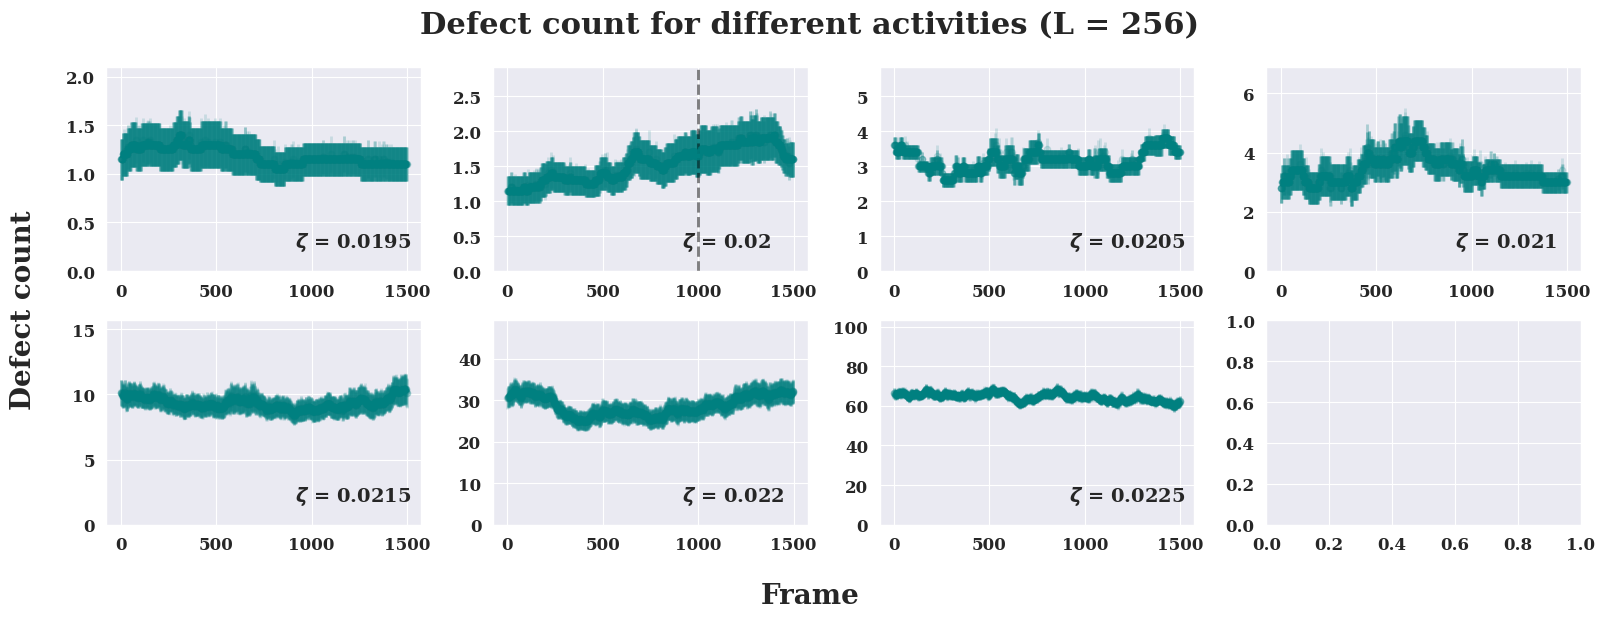

In [47]:
# check that conv_list is good for each dataset
act_min_idx = 0
fig, ax = ad.plot_defects_per_activity(Ndataset=3, act_min_idx = act_min_idx, act_max_idx = act_min_idx + 8, use_merged=use_merged, save=True)


Non-converged fits (p < 0.05):  0


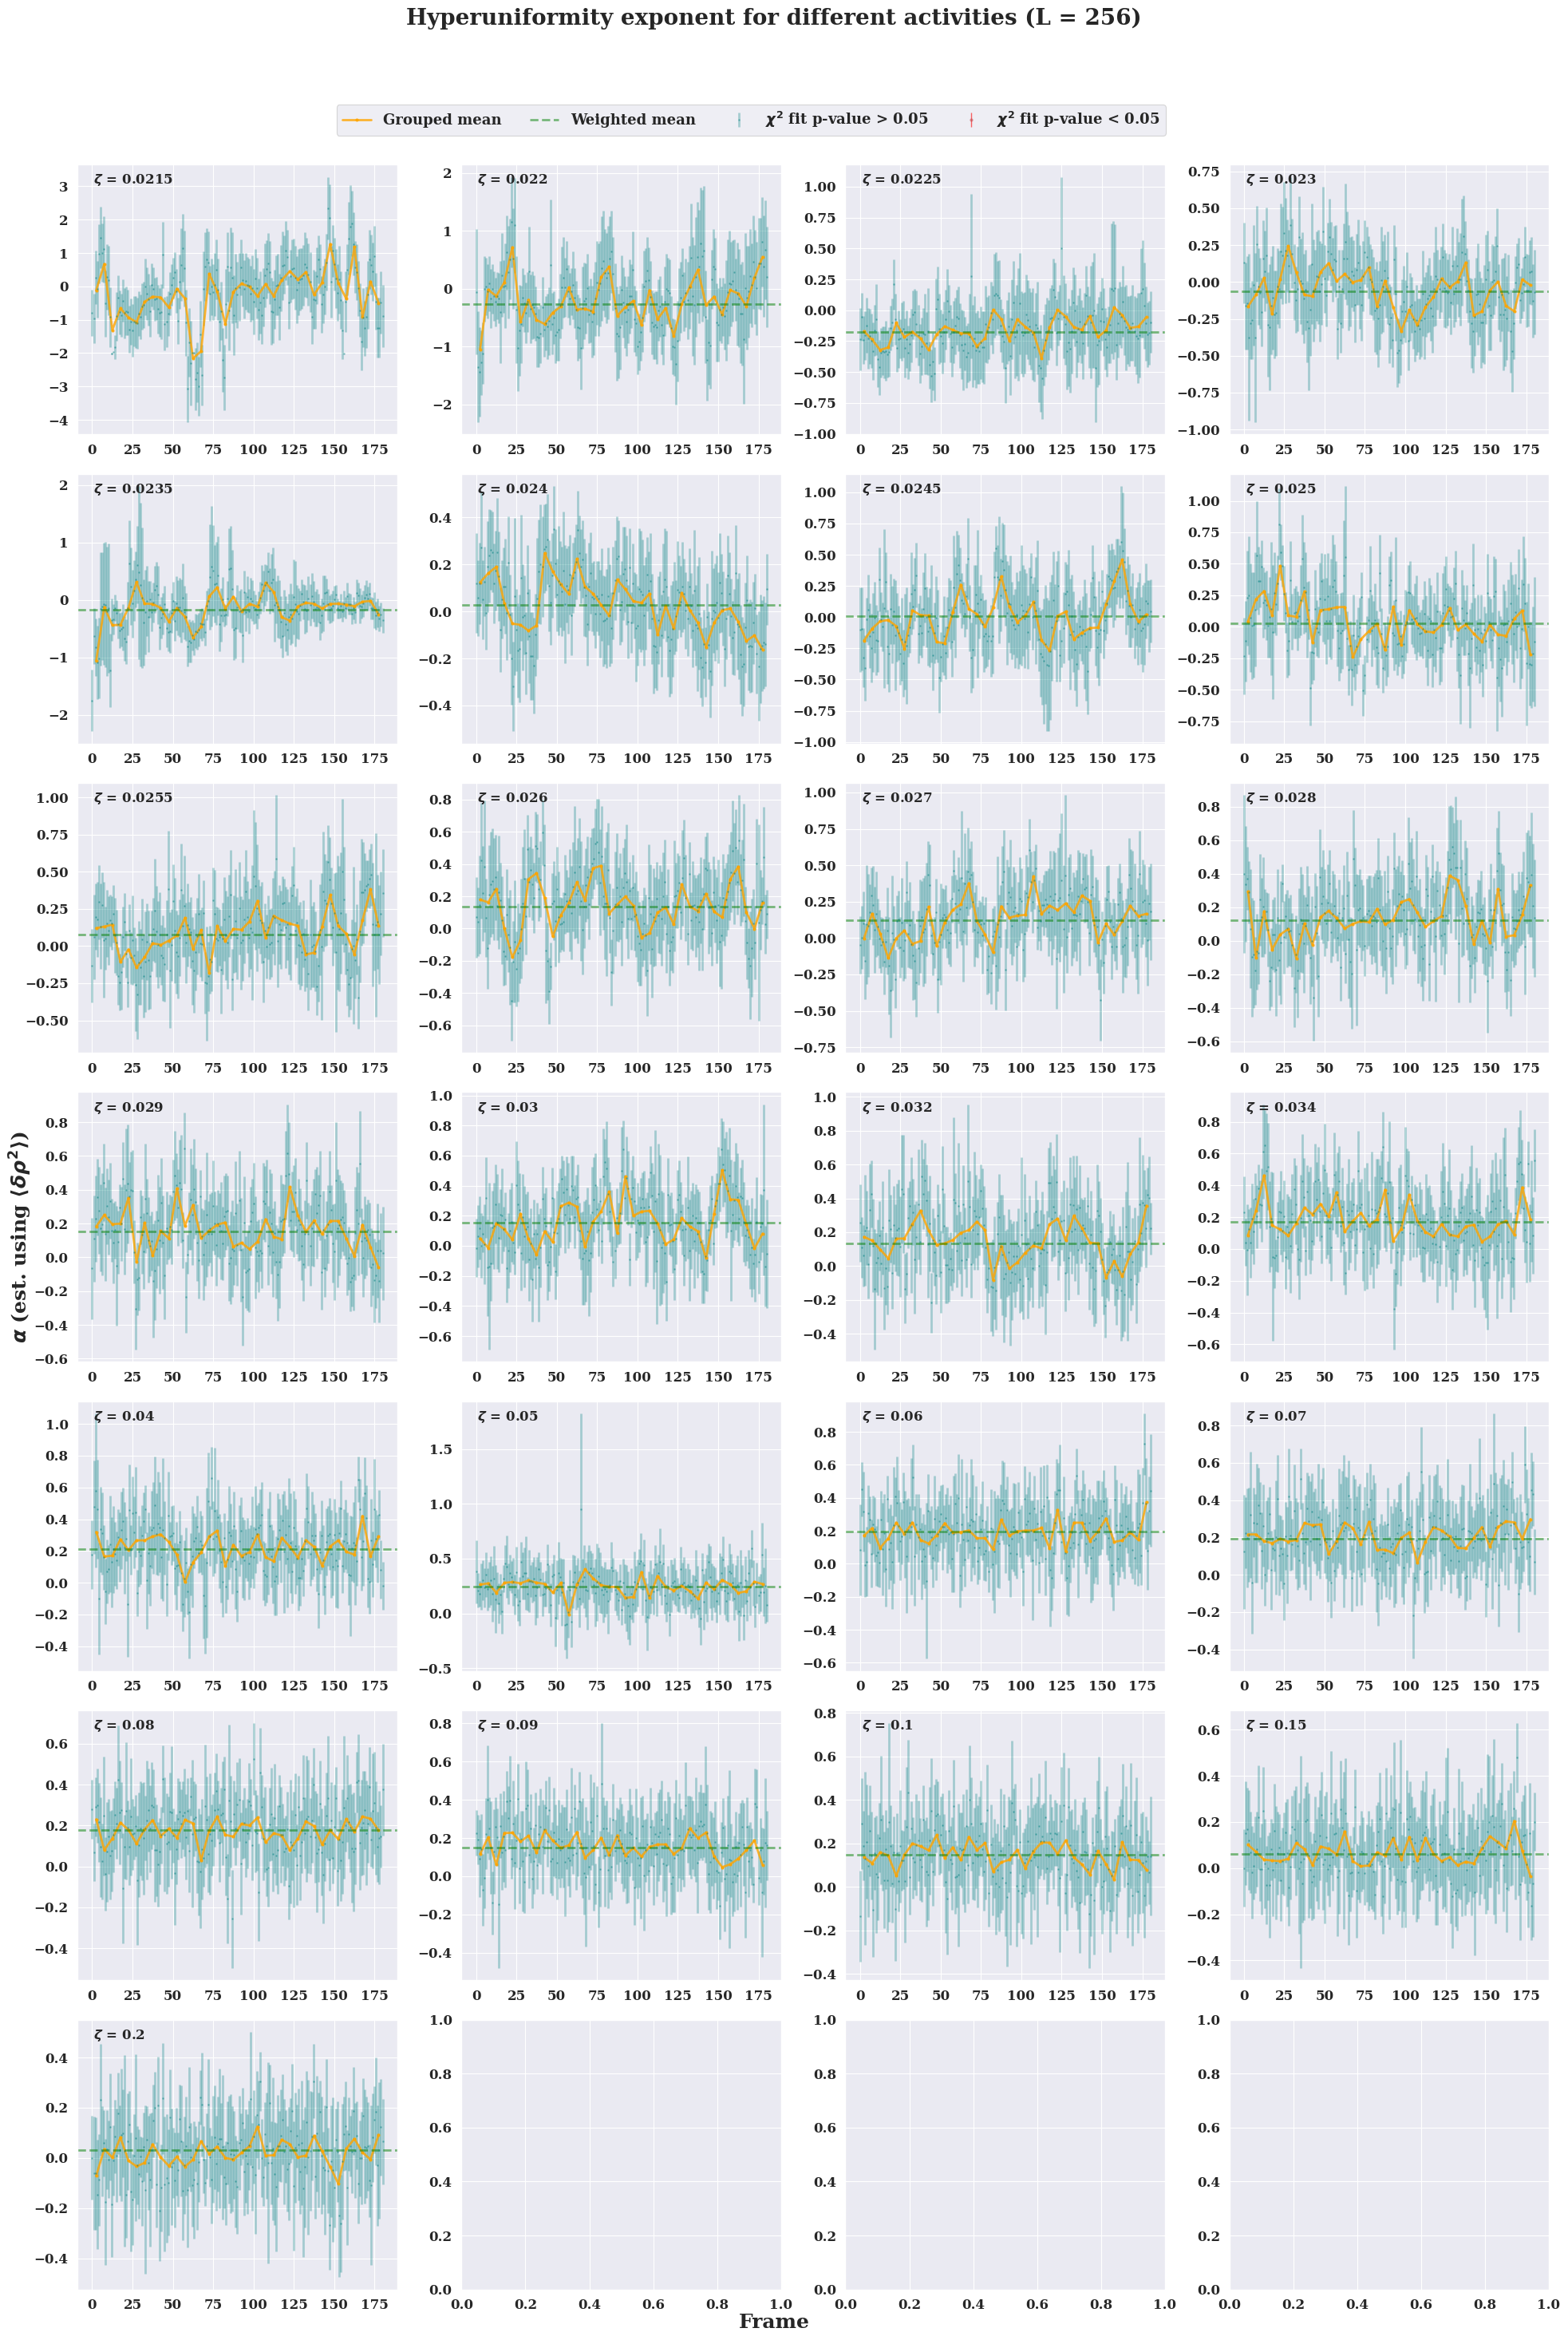

In [195]:
fitp_dens, statp_dens = ad.analyze_hyperuniformity(Ndataset = 3, fit_densities=True, save = True, \
                    weighted_mean = False, plot = True, use_merged = use_merged,\
                     act_idx_bounds=act_idx_bounds, window_idx_bounds=[30 - Npoints_to_fit, None]);


In [ ]:
#fig, ax = ad.plot_alpha_mean(Ndataset = 0, include=['fluc', 'sfac_time_av', 'sfac_time_av_unweighted'], use_merged = use_merged, save = True);
fig, ax = ad.plot_alpha_mean(Ndataset = 3, include=['fluc'],\
             use_merged = use_merged, save = False,);
ax.set_ylim(bottom = -.65, top=.38)
ax.set_xlim(left = 0.019, right=.03)
ax.legend(ncol=1, loc = 'lower right')
output_path = f'data\\nematic_analysis{LL}_LL0.05\\merged_results'
fig_name = 'alpha_mean_transition.png'
#fig.savefig(os.path.join(output_path, f'figs\\{fig_name}'), dpi = 420, pad_inches=0.25)

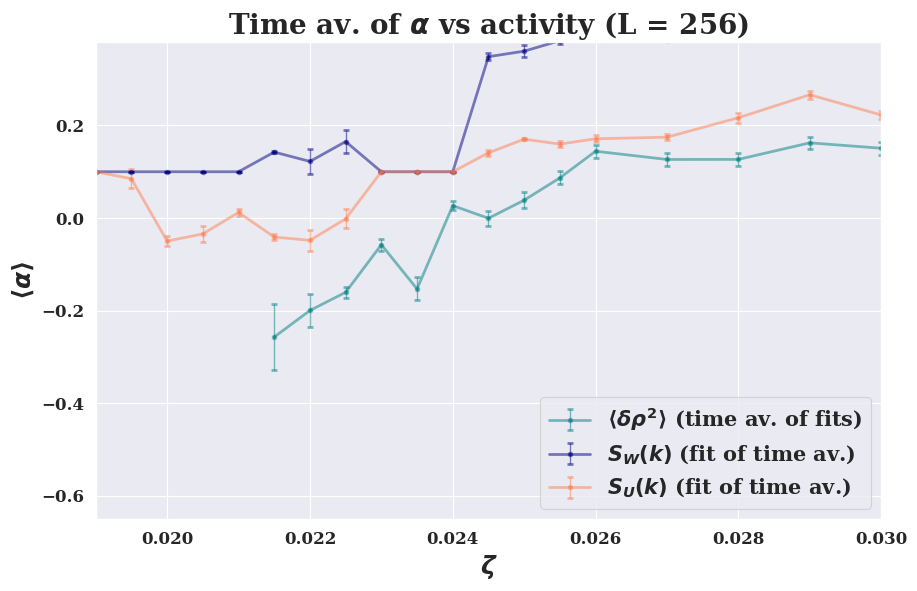

In [174]:
#fig, ax = ad.plot_alpha_mean(Ndataset = 0, include=['fluc', 'sfac_time_av', 'sfac_time_av_unweighted'], use_merged = use_merged, save = True);
fig, ax = ad.plot_alpha_mean(Ndataset = 0, include=['fluc', 'sfac_time_av', 'sfac_time_av_unweighted'],\
             use_merged = use_merged, save = True,);
ax.set_ylim(bottom = -.65, top=.38)
ax.set_xlim(left = 0.019, right=.03)
ax.legend(ncol=1, loc = 'lower right')
output_path = f'data\\nematic_analysis{LL}_LL0.05\\merged_results'
fig_name = 'alpha_mean_transition.png'
#fig.savefig(os.path.join(output_path, f'figs\\{fig_name}'), dpi = 420, pad_inches=0.25)


In [ ]:
Nbounds = [3,7]

fitp = ad.analyze_sfac_time_av(Ndataset=3,Npoints_bounds = Nbounds, weighted = False, act_idx_bounds=act_idx_bounds, use_merged = use_merged,save = True, plot = False);
ad.analyze_sfac_time_av(Ndataset=3,Npoints_bounds = Nbounds, weighted = True, act_idx_bounds=act_idx_bounds, use_merged = use_merged, save = True, plot = False,);
#fitpp = ad.analyze_sfac2(Ndataset=0, Npoints_bounds = Nbounds, weighted = True, act_idx_bounds = act_idx_bounds, use_merged = use_merged, save = True, plot = False);
#ad.analyze_sfac2(Ndataset=0, Npoints_bounds = Nbounds, weighted = False, act_idx_bounds = act_idx_bounds, use_merged = use_merged, save = True, plot = False);
ad.plot_alpha_mean(Ndataset = 3, include=['fluc', 'sfac_time_av', 'sfac_time_av_unweighted'], use_merged = use_merged, save = True);

Non-converged fits (p < 0.01):  3086
Non-converged fits (p < 0.01):  212


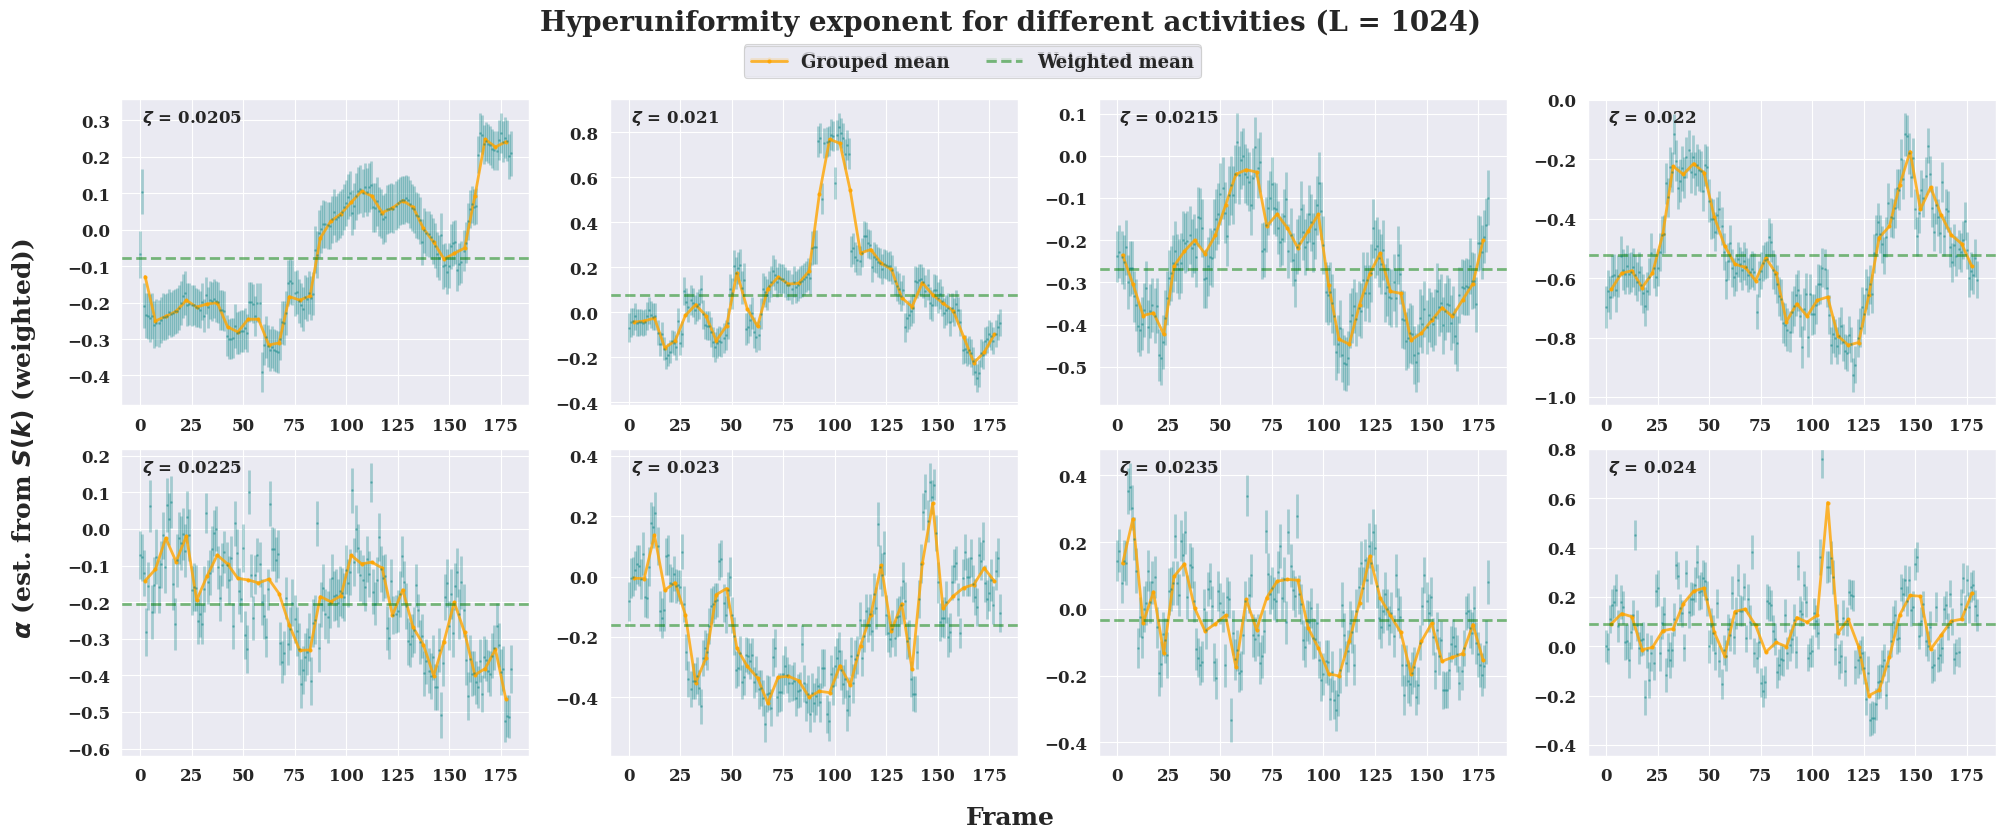

In [262]:
Npoints_to_fit = 5
act_idx_min = 3
fitpp = ad.analyze_sfac(Ndataset=0, Npoints_to_fit = Npoints_to_fit, weighted = True, act_idx_bounds = act_idx_bounds, use_merged = use_merged, save = True, plot = False);
ad.analyze_sfac(Ndataset=0, Npoints_to_fit = Npoints_to_fit, weighted = False, act_idx_bounds = act_idx_bounds, use_merged = use_merged, save = True, plot = False);
fig, ax = ad.plot_hyperuniformity_sfac(act_idx_bounds=[act_idx_min,act_idx_min + 8], use_merged = True, weighted = True, save = True)

output_path = f'data\\nematic_analysis{LL}_LL0.05\\merged_results'
fig_name = 'alpha_sfac.png'
fig.legend(ncol=4, fontsize = 13,bbox_to_anchor=(0.6, 1.00))
fig.supylabel(rf'$\alpha$ (est. from $S(k)$ (weighted))', x = 0.0)
fig.suptitle(f'Hyperuniformity exponent for different activities (L = {LL})', y=1.035)
fig.savefig(os.path.join(output_path, f'figs\\{fig_name}'), dpi = 420, pad_inches=0.1)
ax[-1].set_ylim(top = .8)
plt.show()

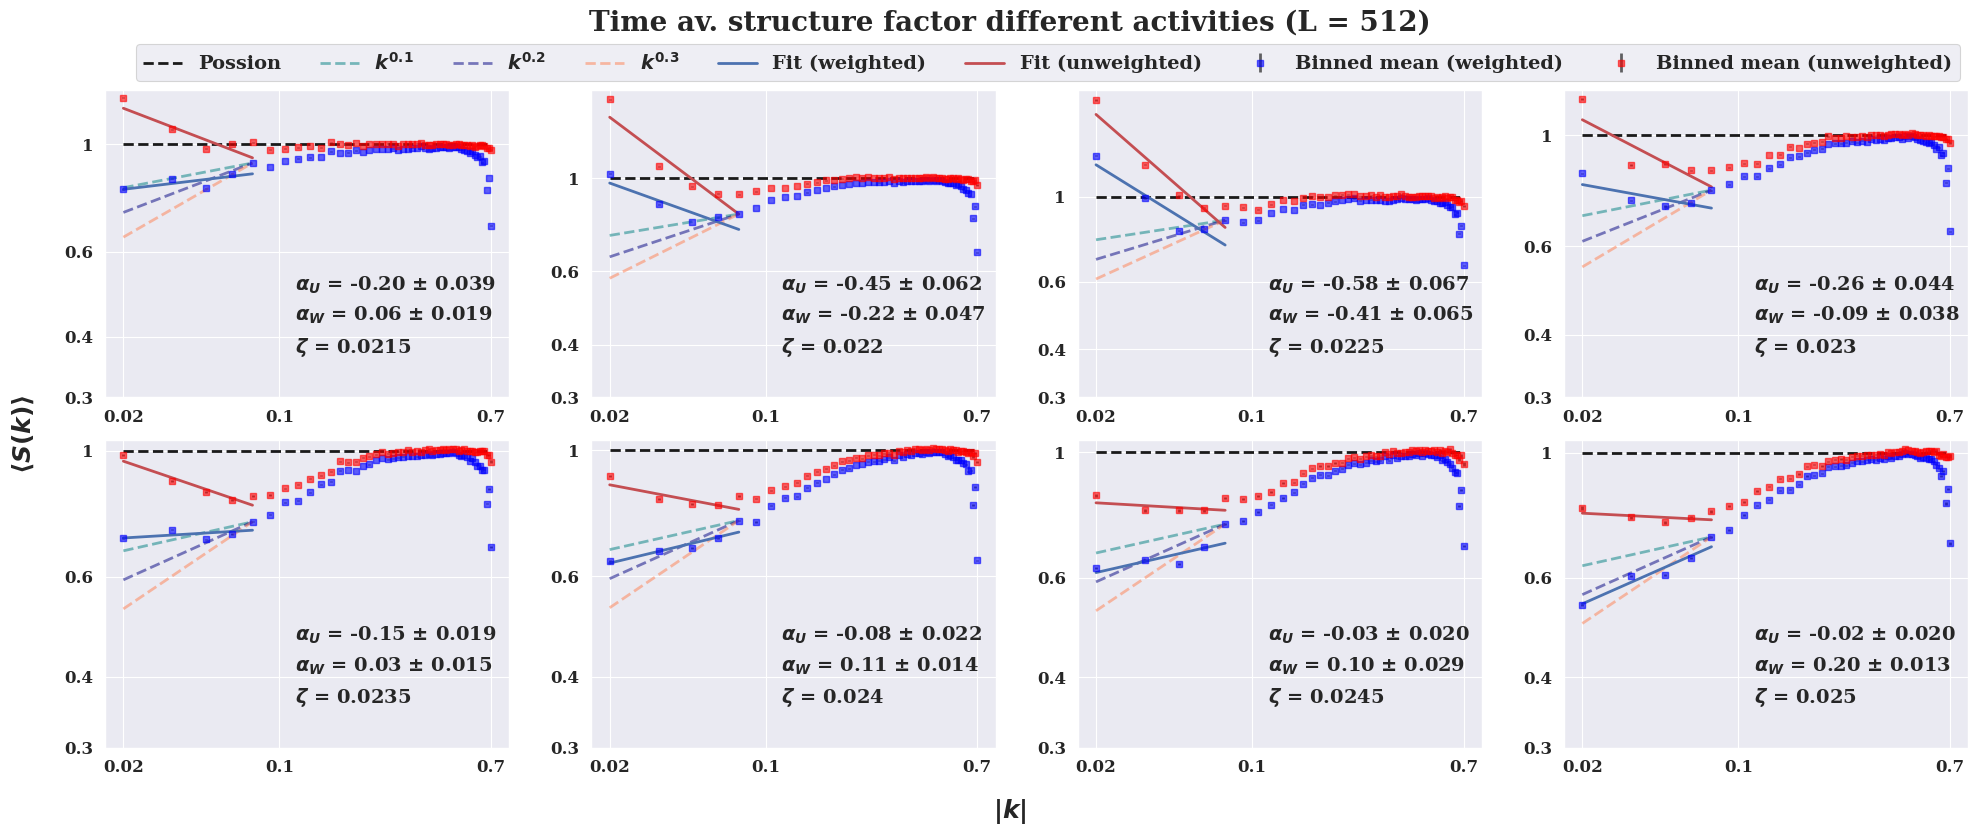

In [18]:
act_idx_min = 6
fig, ax = ad.plot_sfac_weighted_vs_unweighted(Npoints_to_fit=5, act_idx_bounds=[act_idx_min,act_idx_min+8], use_merged=use_merged, save = False)

c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


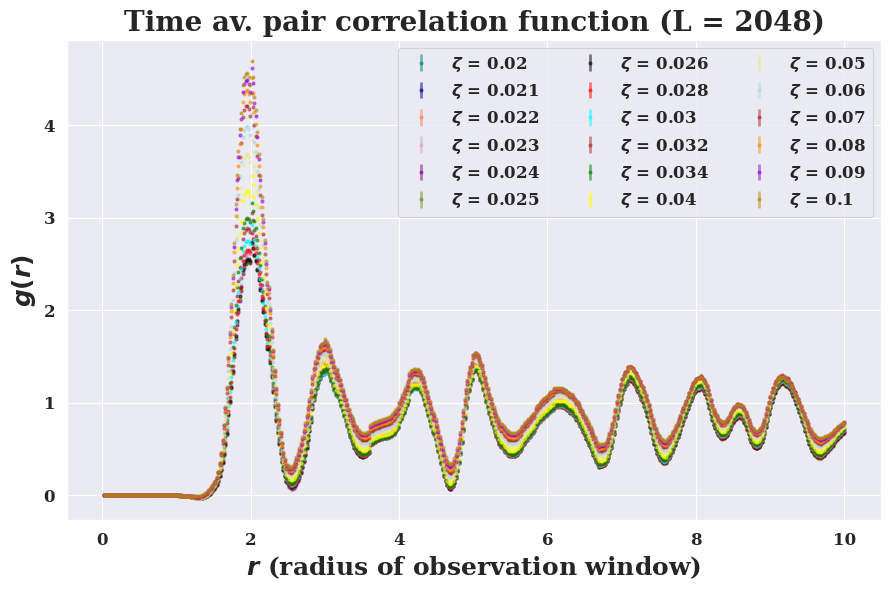

In [246]:
fig, ax = ad.plot_pair_corr_function_time_av(act_idx_bounds=[0,-1], use_merged=use_merged, save = True)
ax.legend(fontsize=12,ncol=3)
output_path = os.path.join(ad.output_main_path, 'merged_results')
fig.savefig(os.path.join(output_path, f'figs\\pcf.png'), dpi = 420, pad_inches=0.25)

No. of windows with max susceptibility at activity 0.022: 22


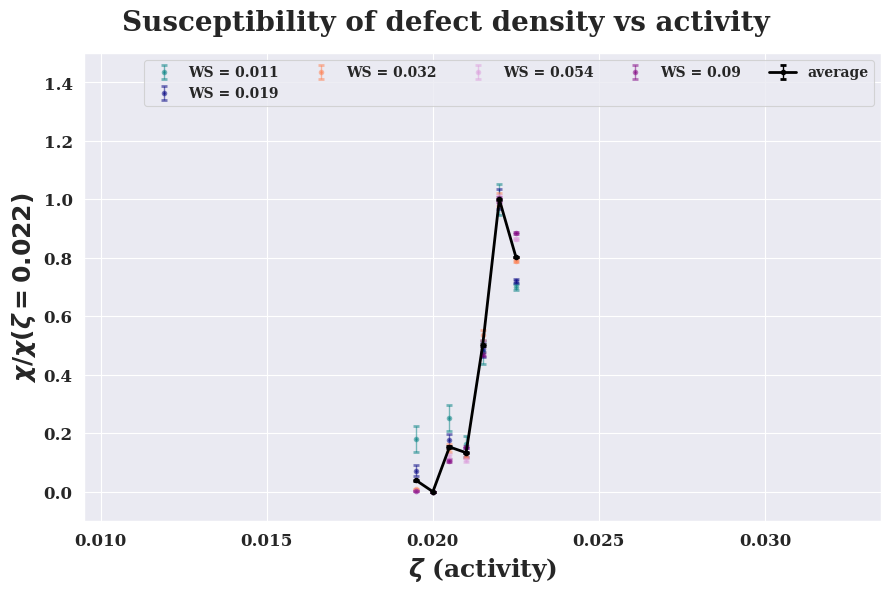

In [39]:
fig, ax = ad.plot_susceptibility(Ndataset=3,Nwindows_jump=5, act_max = 0.022, use_merged=use_merged, act_idx_bounds=[0,None], window_idx_bounds=[8,None])


(<Figure size 900x600 with 1 Axes>,
 <Axes: xlabel=' $\\zeta$ (activity)', ylabel='$U(\\rho)$'>)

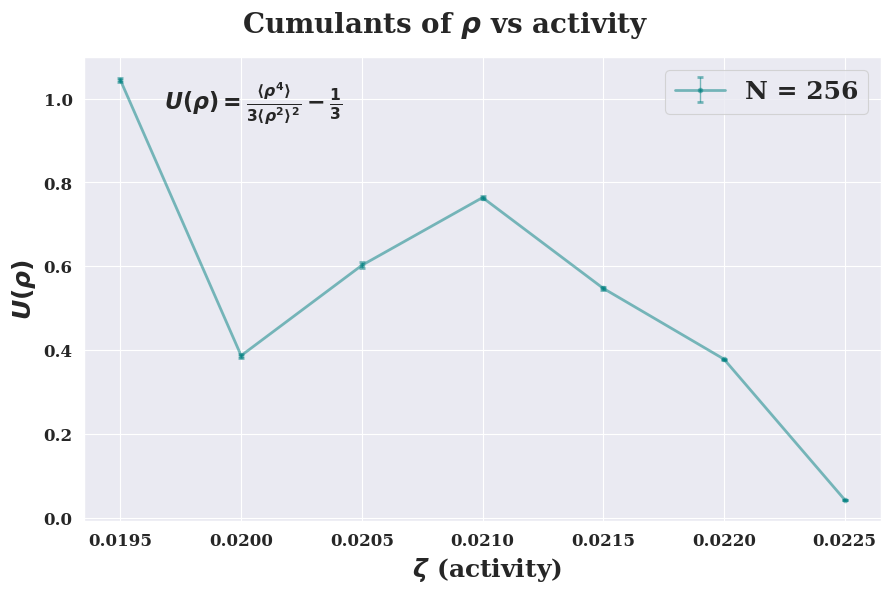

In [41]:
ad.plot_binder_cumulants(Ndataset=3, act_idx_bounds=[0,None], use_merged=use_merged,)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
minn = 0
maxx = None
window_idx_bounds_list=[[minn, maxx], [minn, 20], [minn, 15], [20, maxx], [20, None], [10, maxx], [10, 20], [10, 25], [15,25], [15, maxx]]
for window in window_idx_bounds_list:
    fitp, statp = ad.analyze_hyperuniformity(fit_densities=True, save = False, plot = False, act_bounds=[8,-2], use_merged = True, window_idx_bounds=window);
    ax.plot(ad.act_list[0][8:-2], np.nanmean(fitp[:,:,0], axis = 0), '.-', label = f'{window[0]}:{window[1]}')
ax.set_ylim([-0.3,0.4])
ax.legend()